In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import re
import unicodedata
import nltk
import csv
import string
from textblob import TextBlob
from nltk.corpus import stopwords
!pip install demoji
nltk.download('all')
import demoji
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 924.7 kB/s eta 0:00:00


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
pd.options.display.max_colwidth = 250

In [4]:
!pip install transformers

# !pip install -q transformers

In [5]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
import torchtext
from torchtext import data

import transformers
from transformers import BertTokenizer, BertModel, BertConfig

import warnings
warnings.filterwarnings('ignore')
import operator

from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

from matplotlib.ticker import StrMethodFormatter

In [6]:
print(transformers.__version__)

4.38.2


In [ ]:
#print(transformers.__version__)

4.38.2


In [7]:
MAX_LEN = 200 #based on length of tweets
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 4
LEARNING_RATE = 1e-05 #tried 1e-03, 1e-04, 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.tweet = dataframe['Tweet']
        self.targets = self.dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, index):
        tweet = str(self.tweet[index])
        tweet = " ".join(tweet.split())

        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            pad_to_max_length = True,
            return_token_type_ids = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids' : torch.tensor(ids, dtype = torch.long),
            'mask' : torch.tensor(mask, dtype = torch.long),
            'token_type_ids' : torch.tensor(token_type_ids, dtype = torch.long),
            'targets' : torch.tensor(self.targets[index], dtype = torch.float)
        }

In [9]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = torch.nn.Dropout(0.3)
        self.layer3 = torch.nn.Linear(768, 10)

    def forward(self, ids, mask, token_type_ids, return_dict = False):
        unw, out_1 = self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[0], self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

model = BERT()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [10]:
bert = torch.load("/content/drive/MyDrive/sbg_miniproject/Notebooks/bertmodel.pth")
bert

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

# Saving Weights

In [11]:
torch.save(model.state_dict(), '/content/drive/MyDrive/sbg_miniproject/Notebooks/weights_only.pth')

# Loading Weights

In [12]:
model_new = BERT()
model_new.to(device)

model_new.load_state_dict(torch.load('/content/drive/MyDrive/sbg_miniproject/Notebooks/weights_only.pth'))

model_new

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [13]:
model_new


BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [14]:
def test():
    bert.eval()
    bert_outputs = []

    with torch.no_grad():
        for unw, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = bert(ids, mask, token_type_ids)

            bert_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return bert_outputs

# Predicting Sentiments

In [15]:
for chapter in range(1, 19):

  new_df = pd.DataFrame()

  verses_df = pd.read_csv('/content/drive/MyDrive/sbg_miniproject/Processed Text Files/eknath easwaran/' + str(chapter) + '.csv')

  new_df['Tweet'] = verses_df['verse']
  values = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * len(verses_df)
  new_df['list'] = values

  test_dataset = CustomDataset(new_df, tokenizer, MAX_LEN)

  bert_test_params = {'batch_size': 1,
                    'shuffle': False,
                    'num_workers': 0
                    }

  test_loader = DataLoader(test_dataset, **bert_test_params)

  test_outputs = test()

  test_outputs = np.array(test_outputs)

  for i in range(test_outputs.shape[0]):
      for j in range(test_outputs.shape[1]):
          if test_outputs[i][j] >= 0.5: test_outputs[i][j] = 1
          else: test_outputs[i][j] = 0

  new_df['Optimistic'] = "None"
  new_df['Thankful'] = "None"
  new_df['Empathetic'] = "None"
  new_df['Pessimistic'] = "None"
  new_df['Anxious'] = "None"
  new_df['Sad'] = "None"
  new_df['Annoyed'] = "None"
  new_df['Denial'] = "None"
  new_df['Official report'] = "None"
  #new_df['Surprise'] = "None"
  new_df['Joking'] = "None"
  new_df = new_df.drop(['list'], axis = 1)

  for i in range(len(test_outputs)):
    new_df['Optimistic'].iloc[i] = test_outputs[i][0]
    new_df['Thankful'].iloc[i] = test_outputs[i][1]
    new_df['Empathetic'].iloc[i] = test_outputs[i][2]
    new_df['Pessimistic'].iloc[i] = test_outputs[i][3]
    new_df['Anxious'].iloc[i] = test_outputs[i][4]
    new_df['Sad'].iloc[i] = test_outputs[i][5]
    new_df['Annoyed'].iloc[i] = test_outputs[i][6]
    new_df['Denial'].iloc[i] = test_outputs[i][7]
    new_df['Official report'].iloc[i] = test_outputs[i][8]
    #new_df['Surprise'].iloc[i] = test_outputs[i][9]
    new_df['Joking'].iloc[i] = test_outputs[i][9]

    new_df.tail(5)

    new_df.to_csv('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/eknatheaswaran/chapter ' + str(chapter) + '.csv')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [16]:
for chapter in range(1, 19):

  new_df = pd.DataFrame()

  verses_df = pd.read_csv('/content/drive/MyDrive/sbg_miniproject/Processed Text Files/purohit swami/' + str(chapter) + '.csv')

  new_df['Tweet'] = verses_df['verse']
  values = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * len(verses_df)
  new_df['list'] = values

  test_dataset = CustomDataset(new_df, tokenizer, MAX_LEN)

  bert_test_params = {'batch_size': 1,
                    'shuffle': False,
                    'num_workers': 0
                    }

  test_loader = DataLoader(test_dataset, **bert_test_params)

  test_outputs = test()

  test_outputs = np.array(test_outputs)

  for i in range(test_outputs.shape[0]):
      for j in range(test_outputs.shape[1]):
          if test_outputs[i][j] >= 0.5: test_outputs[i][j] = 1
          else: test_outputs[i][j] = 0

  new_df['Optimistic'] = "None"
  new_df['Thankful'] = "None"
  new_df['Empathetic'] = "None"
  new_df['Pessimistic'] = "None"
  new_df['Anxious'] = "None"
  new_df['Sad'] = "None"
  new_df['Annoyed'] = "None"
  new_df['Denial'] = "None"
  new_df['Official report'] = "None"
  #new_df['Surprise'] = "None"
  new_df['Joking'] = "None"
  new_df = new_df.drop(['list'], axis = 1)

  for i in range(len(test_outputs)):
    new_df['Optimistic'].iloc[i] = test_outputs[i][0]
    new_df['Thankful'].iloc[i] = test_outputs[i][1]
    new_df['Empathetic'].iloc[i] = test_outputs[i][2]
    new_df['Pessimistic'].iloc[i] = test_outputs[i][3]
    new_df['Anxious'].iloc[i] = test_outputs[i][4]
    new_df['Sad'].iloc[i] = test_outputs[i][5]
    new_df['Annoyed'].iloc[i] = test_outputs[i][6]
    new_df['Denial'].iloc[i] = test_outputs[i][7]
    new_df['Official report'].iloc[i] = test_outputs[i][8]
    #new_df['Surprise'].iloc[i] = test_outputs[i][9]
    new_df['Joking'].iloc[i] = test_outputs[i][9]

    new_df.tail(5)

    new_df.to_csv('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/purohitswami/chapter ' + str(chapter) + '.csv')

In [17]:
for chapter in range(1, 19):

  new_df = pd.DataFrame()

  verses_df = pd.read_csv('/content/drive/MyDrive/sbg_miniproject/Processed Text Files/mahatma gandhi/' + str(chapter) + '.csv')

  new_df['Tweet'] = verses_df['verse']
  values = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * len(verses_df)
  new_df['list'] = values

  test_dataset = CustomDataset(new_df, tokenizer, MAX_LEN)

  bert_test_params = {'batch_size': 1,
                    'shuffle': False,
                    'num_workers': 0
                    }

  test_loader = DataLoader(test_dataset, **bert_test_params)

  test_outputs = test()

  test_outputs = np.array(test_outputs)

  for i in range(test_outputs.shape[0]):
      for j in range(test_outputs.shape[1]):
          if test_outputs[i][j] >= 0.5: test_outputs[i][j] = 1
          else: test_outputs[i][j] = 0

  new_df['Optimistic'] = "None"
  new_df['Thankful'] = "None"
  new_df['Empathetic'] = "None"
  new_df['Pessimistic'] = "None"
  new_df['Anxious'] = "None"
  new_df['Sad'] = "None"
  new_df['Annoyed'] = "None"
  new_df['Denial'] = "None"
  new_df['Official report'] = "None"
  #new_df['Surprise'] = "None"
  new_df['Joking'] = "None"
  new_df = new_df.drop(['list'], axis = 1)

  for i in range(len(test_outputs)):
    new_df['Optimistic'].iloc[i] = test_outputs[i][0]
    new_df['Thankful'].iloc[i] = test_outputs[i][1]
    new_df['Empathetic'].iloc[i] = test_outputs[i][2]
    new_df['Pessimistic'].iloc[i] = test_outputs[i][3]
    new_df['Anxious'].iloc[i] = test_outputs[i][4]
    new_df['Sad'].iloc[i] = test_outputs[i][5]
    new_df['Annoyed'].iloc[i] = test_outputs[i][6]
    new_df['Denial'].iloc[i] = test_outputs[i][7]
    new_df['Official report'].iloc[i] = test_outputs[i][8]
    #new_df['Surprise'].iloc[i] = test_outputs[i][9]
    new_df['Joking'].iloc[i] = test_outputs[i][9]

    new_df.tail(5)

    new_df.to_csv('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/mahatmagandhi/chapter ' + str(chapter) + '.csv')

# Cumulative sentiments of all chapters plotted using bar plots

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Optimistic'),
  Text(1, 0, 'Thankful'),
  Text(2, 0, 'Empathetic'),
  Text(3, 0, 'Pessimistic'),
  Text(4, 0, 'Anxious'),
  Text(5, 0, 'Sad'),
  Text(6, 0, 'Annoyed'),
  Text(7, 0, 'Denial'),
  Text(8, 0, 'Joking')])

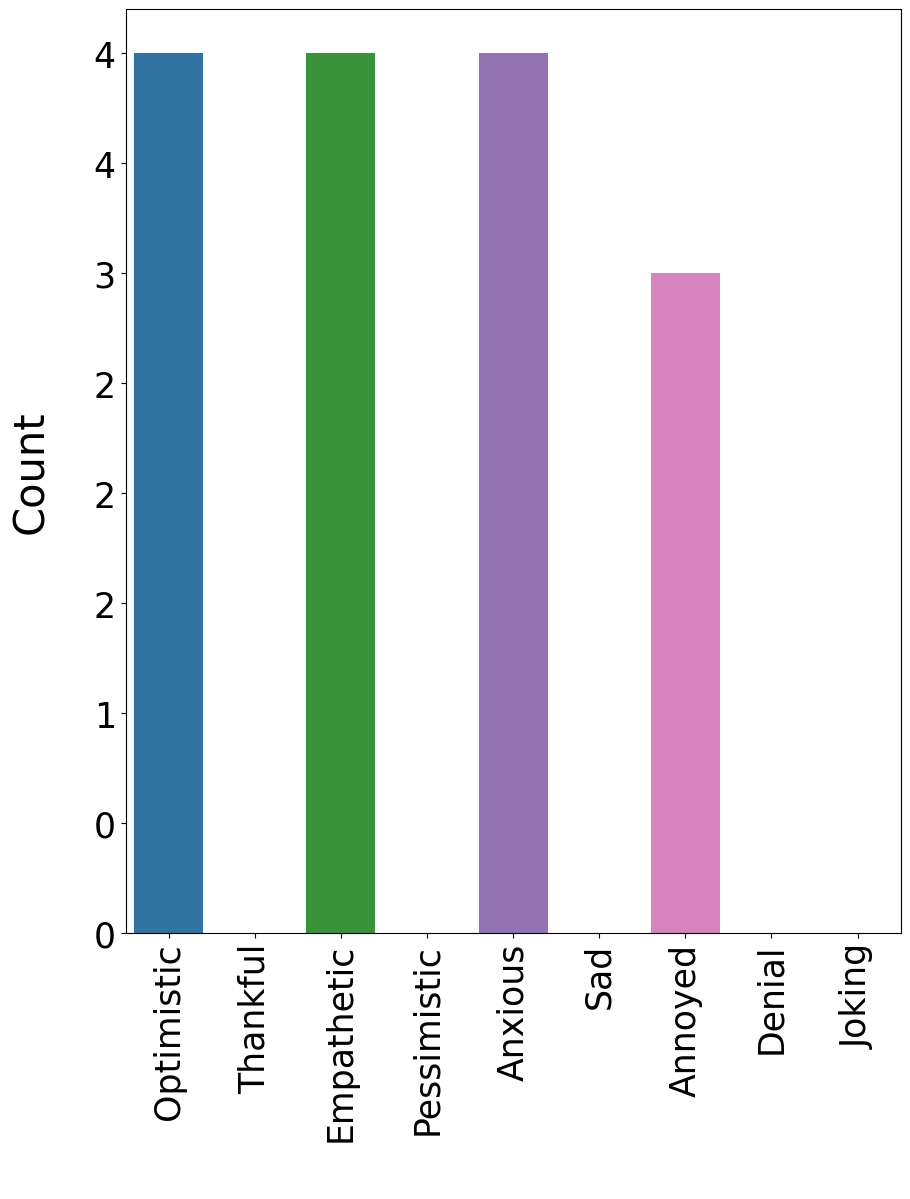

In [19]:
dfs = []


for chapter in range(1,19):
  df = pd.read_csv('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/eknatheaswaran/chapter ' + str(chapter) + '.csv')

  df = df.drop(['Unnamed: 0','Official report'], axis=1)
  df = df.apply(pd.Series.value_counts)

  df['Optimistic'] = df['Optimistic'].fillna(0)
  df['Thankful'] = df['Thankful'].fillna(0)
  df['Empathetic'] = df['Empathetic'].fillna(0)
  df['Pessimistic'] = df['Pessimistic'].fillna(0)
  df['Anxious'] = df['Anxious'].fillna(0)
  df['Sad'] = df['Sad'].fillna(0)
  df['Annoyed'] = df['Annoyed'].fillna(0)
  df['Denial'] = df['Denial'].fillna(0)
  #df['Official report'] = df['Official report'].fillna(0)
  #df['Surprise'] = df['Surprise'].fillna(0)
  df['Joking'] = df['Joking'].fillna(0)

  df = df.iloc[1]

  df = pd.DataFrame(df)

  df.columns = ['Count']

  dfs.append(df)

# Concatenate all DataFrames in the list
total_df1 = pd.concat(dfs, ignore_index=True)

# Perform necessary renaming and resetting of index
total_df1 = total_df1.rename(columns={"index": "Sentiment"})
total_df1.reset_index(drop=True, inplace=True)

new_df = pd.DataFrame({"Sentiment":["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Joking"],
                       "Count":[0,0,0,0,0,0,0,0,0]})

for ii in range(0, 8):
  for jj in range(0, 18):
    new_df.loc[ii,'Count'] = (new_df.loc[ii,'Count'] + total_df1.loc[jj*8+ii,'Count']).astype(int)

fig_dims = (10, 12)
fig, ax = plt.subplots(figsize=fig_dims)


sns.barplot(x = new_df.Sentiment, y = new_df.Count, ax = ax, palette = sns.color_palette("tab10"))

plt.xticks(rotation=90)

plt.ylabel('Count', labelpad=30)
plt.xlabel(' ')
# plt.title('All Chapters', fontsize = 25,  pad=25)
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
plt.yticks(fontsize= 25)
plt.xticks(fontsize = 25)

In [20]:
def all_chapter_dataframe(path):
  dfs=[]

  for chapter in range(1,19):
    df = pd.read_csv(path + str(chapter)+'.csv')

    df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
    df = df.apply(pd.Series.value_counts)

    df['Optimistic'] = df['Optimistic'].fillna(0)
    df['Thankful'] = df['Thankful'].fillna(0)
    df['Empathetic'] = df['Empathetic'].fillna(0)
    df['Pessimistic'] = df['Pessimistic'].fillna(0)
    df['Anxious'] = df['Anxious'].fillna(0)
    df['Sad'] = df['Sad'].fillna(0)
    df['Annoyed'] = df['Annoyed'].fillna(0)
    df['Denial'] = df['Denial'].fillna(0)
    #df['Official report'] = df['Official report'].fillna(0)
    #df['Surprise'] = df['Surprise'].fillna(0)
    df['Joking'] = df['Joking'].fillna(0)

    df = df.iloc[1]

    df = pd.DataFrame(df)

    df.columns = [ 'Count']

    dfs.append(df)

  total_df1 = pd.concat(dfs, ignore_index=True)
  total_df1 = total_df1.rename(columns={"index":"Sentiment"})
  total_df1.reset_index(drop=True, inplace=True)


  new_df = pd.DataFrame({"Sentiment":["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Joking"],
                       "Count":[0,0,0,0,0,0,0,0,0]})

  for ii in range(0, 8):
    for jj in range(0, 18):
      new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df1.loc[jj*8+ii, 'Count']).astype(int)

  return new_df

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Optimistic'),
  Text(1, 0, 'Thankful'),
  Text(2, 0, 'Empathetic'),
  Text(3, 0, 'Pessimistic'),
  Text(4, 0, 'Anxious'),
  Text(5, 0, 'Sad'),
  Text(6, 0, 'Annoyed'),
  Text(7, 0, 'Denial'),
  Text(8, 0, 'Joking')])

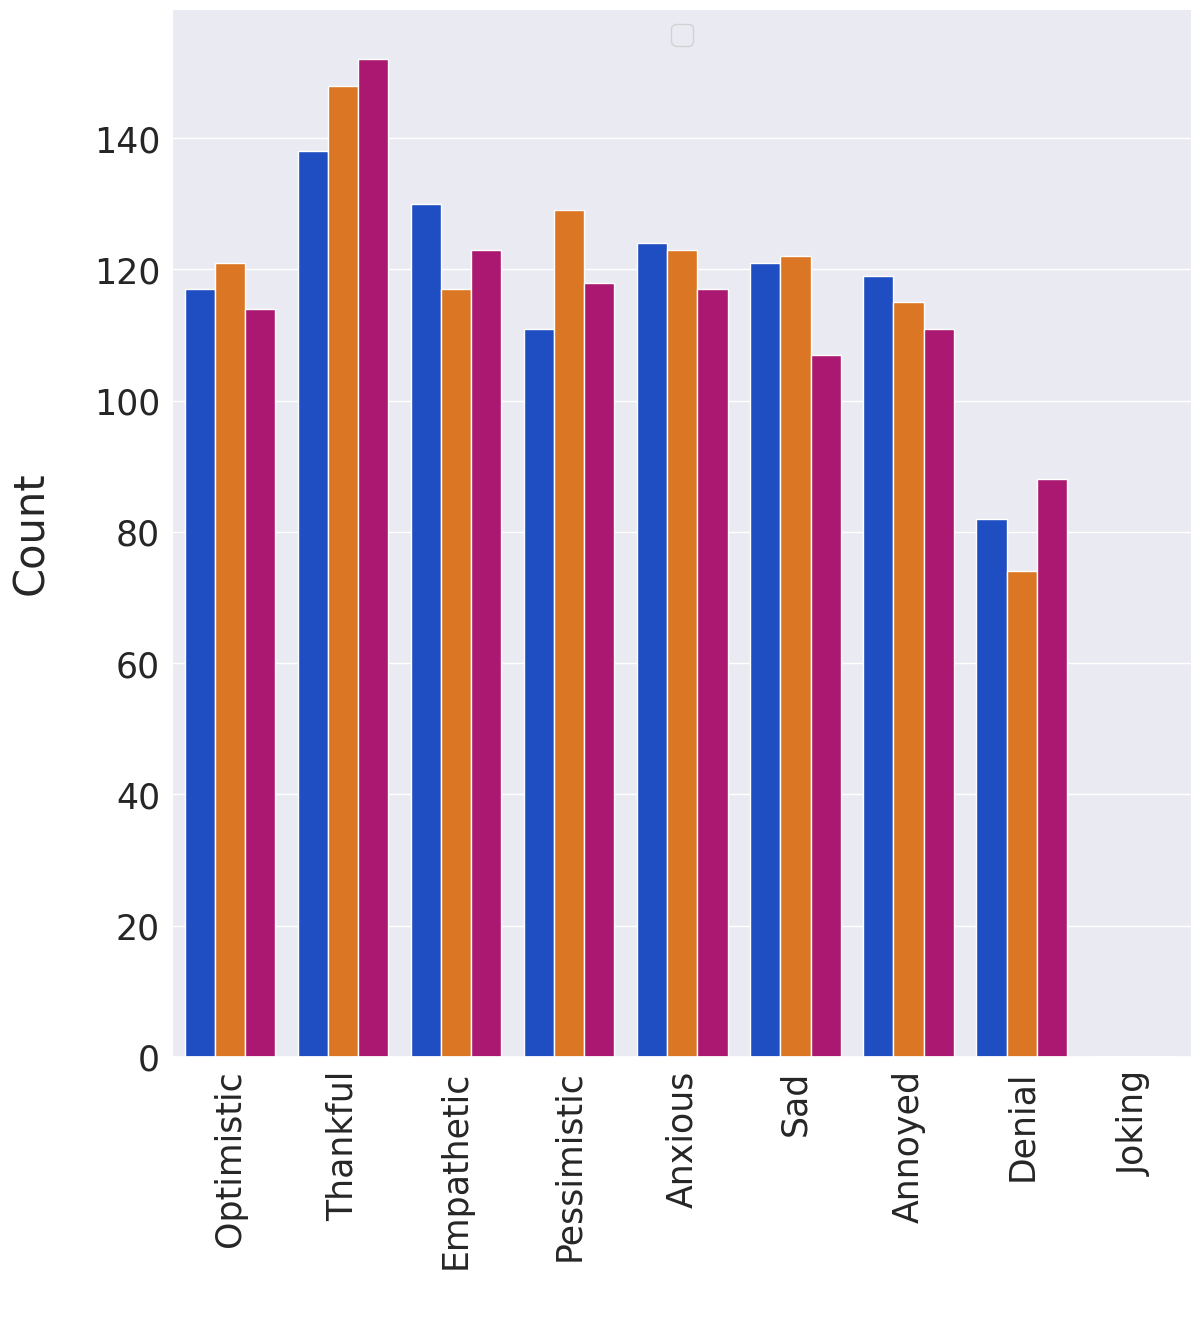

In [ ]:
eknath_easwaran = all_chapter_dataframe('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/eknatheaswaran/chapter ')
mahatma_gandhi = all_chapter_dataframe('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/mahatmagandhi/chapter ')
purohit_swami = all_chapter_dataframe('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/purohitswami/chapter ')

df_new = pd.concat([eknath_easwaran, mahatma_gandhi['Count'], purohit_swami['Count']], axis=1)

df_new.columns = ['Sentiment', 'Eknath Easwaran', 'Mahatma Gandhi', 'Purohit Swami']

df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")

# sns.color_palette("tab10")

# sns.factorplot(x='Sentiment', y='Count', hue='Author', data=df_new, kind='bar', height=10, palette = "tab10")

colors = ["blue", "orange", "magenta"]
myPalette = sns.xkcd_palette(colors)

sns.set_style("darkgrid")
g = sns.catplot(x='Sentiment', y='Count', hue='Author', data=df_new, kind='bar', height=12, palette = myPalette, legend=False)

g.despine(left=True)

plt.legend(loc='upper center',prop={"size":20})

plt.ylabel('Count', labelpad=30, fontsize=30)
plt.xlabel(' ')

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
plt.yticks(fontsize= 25)
plt.xticks(fontsize = 25)
plt.xticks(rotation=90)



# Chapter-wise sentiments

In [ ]:
def chapter_wise_dataframe(path, chapter):

    df = pd.read_csv(path + str(chapter)+'.csv')

    df = df.drop(['Tweet', 'Unnamed: 0','Official report'], axis=1)
    df = df.apply(pd.Series.value_counts)

    df['Optimistic'] = df['Optimistic'].fillna(0)
    df['Thankful'] = df['Thankful'].fillna(0)
    df['Empathetic'] = df['Empathetic'].fillna(0)
    df['Pessimistic'] = df['Pessimistic'].fillna(0)
    df['Anxious'] = df['Anxious'].fillna(0)
    df['Sad'] = df['Sad'].fillna(0)
    df['Annoyed'] = df['Annoyed'].fillna(0)
    df['Denial'] = df['Denial'].fillna(0)
    #df['Official report'] = df['Official report'].fillna(0)
    #df['Surprise'] = df['Surprise'].fillna(0)
    df['Joking'] = df['Joking'].fillna(0)

    df = df.iloc[1]

    df = pd.DataFrame(df)

    df.columns = [ 'Count']

    return df

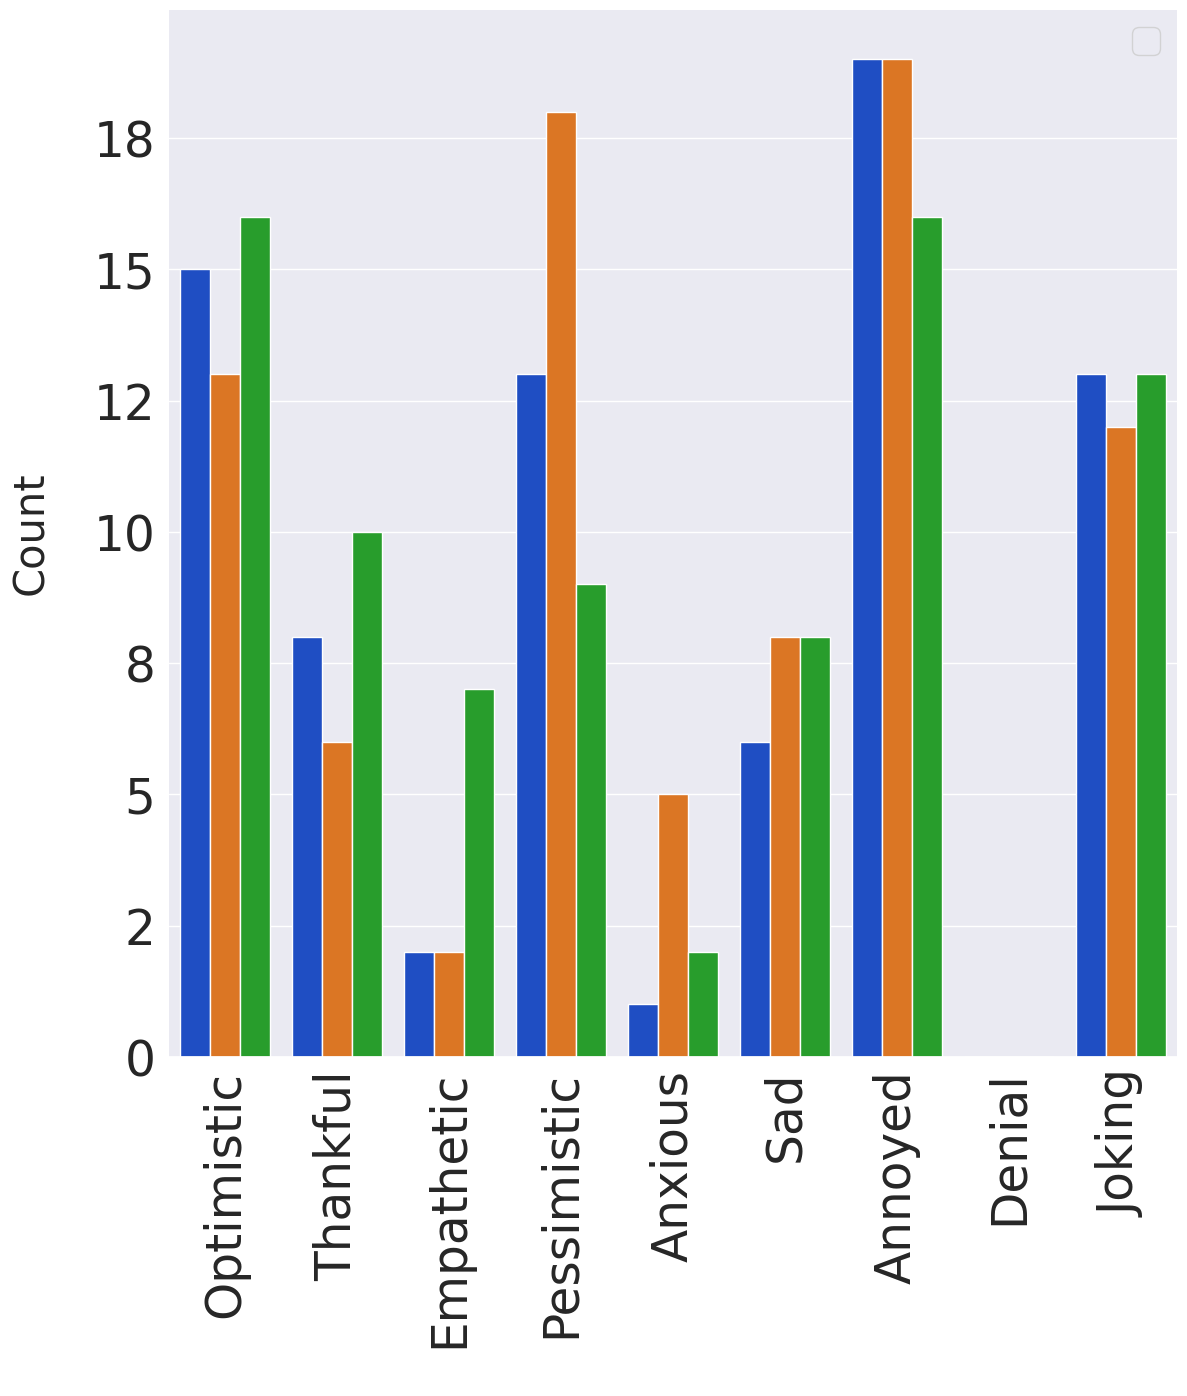

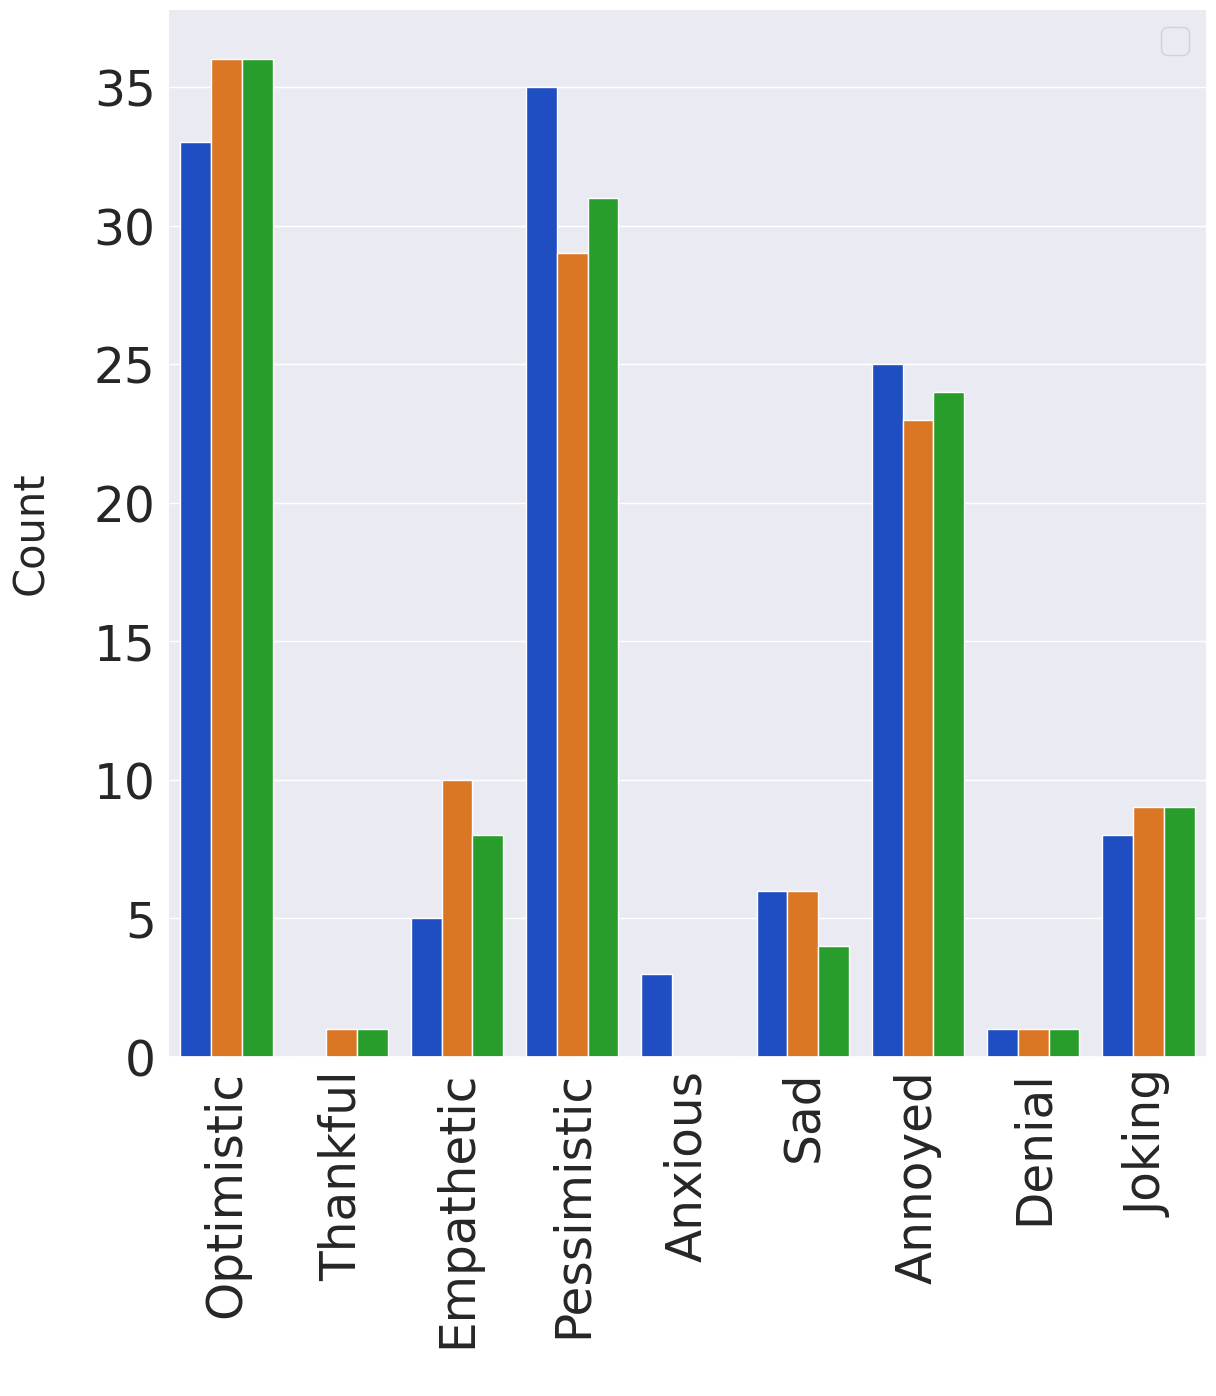

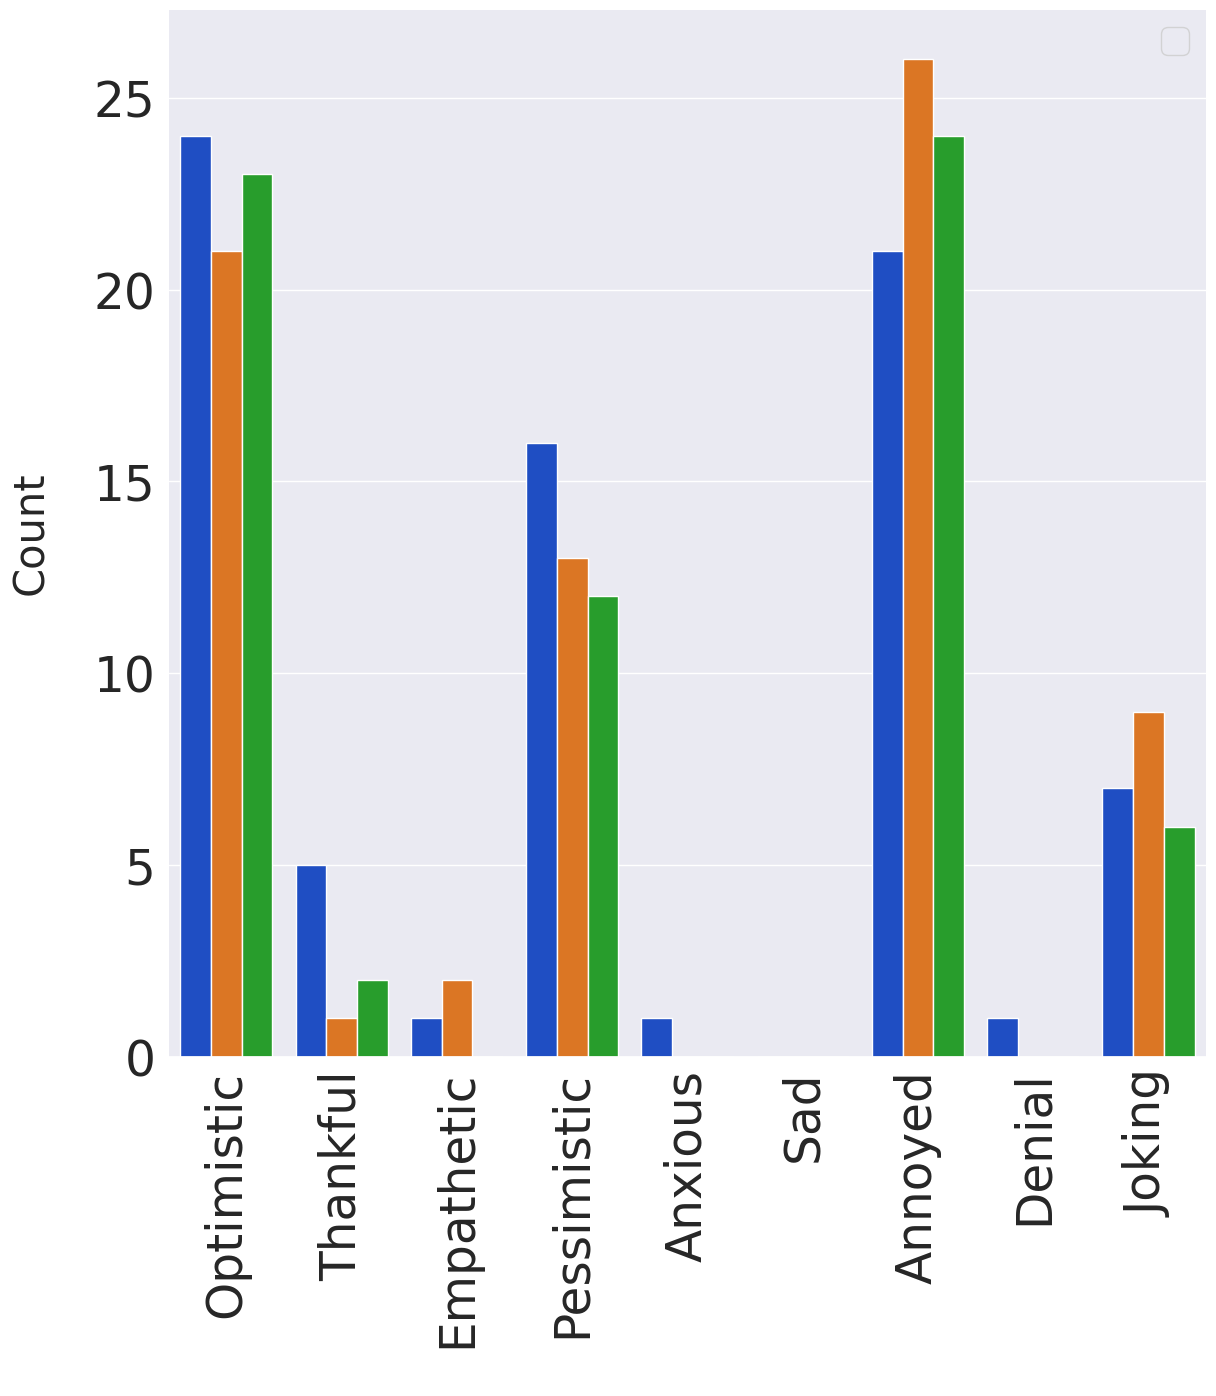

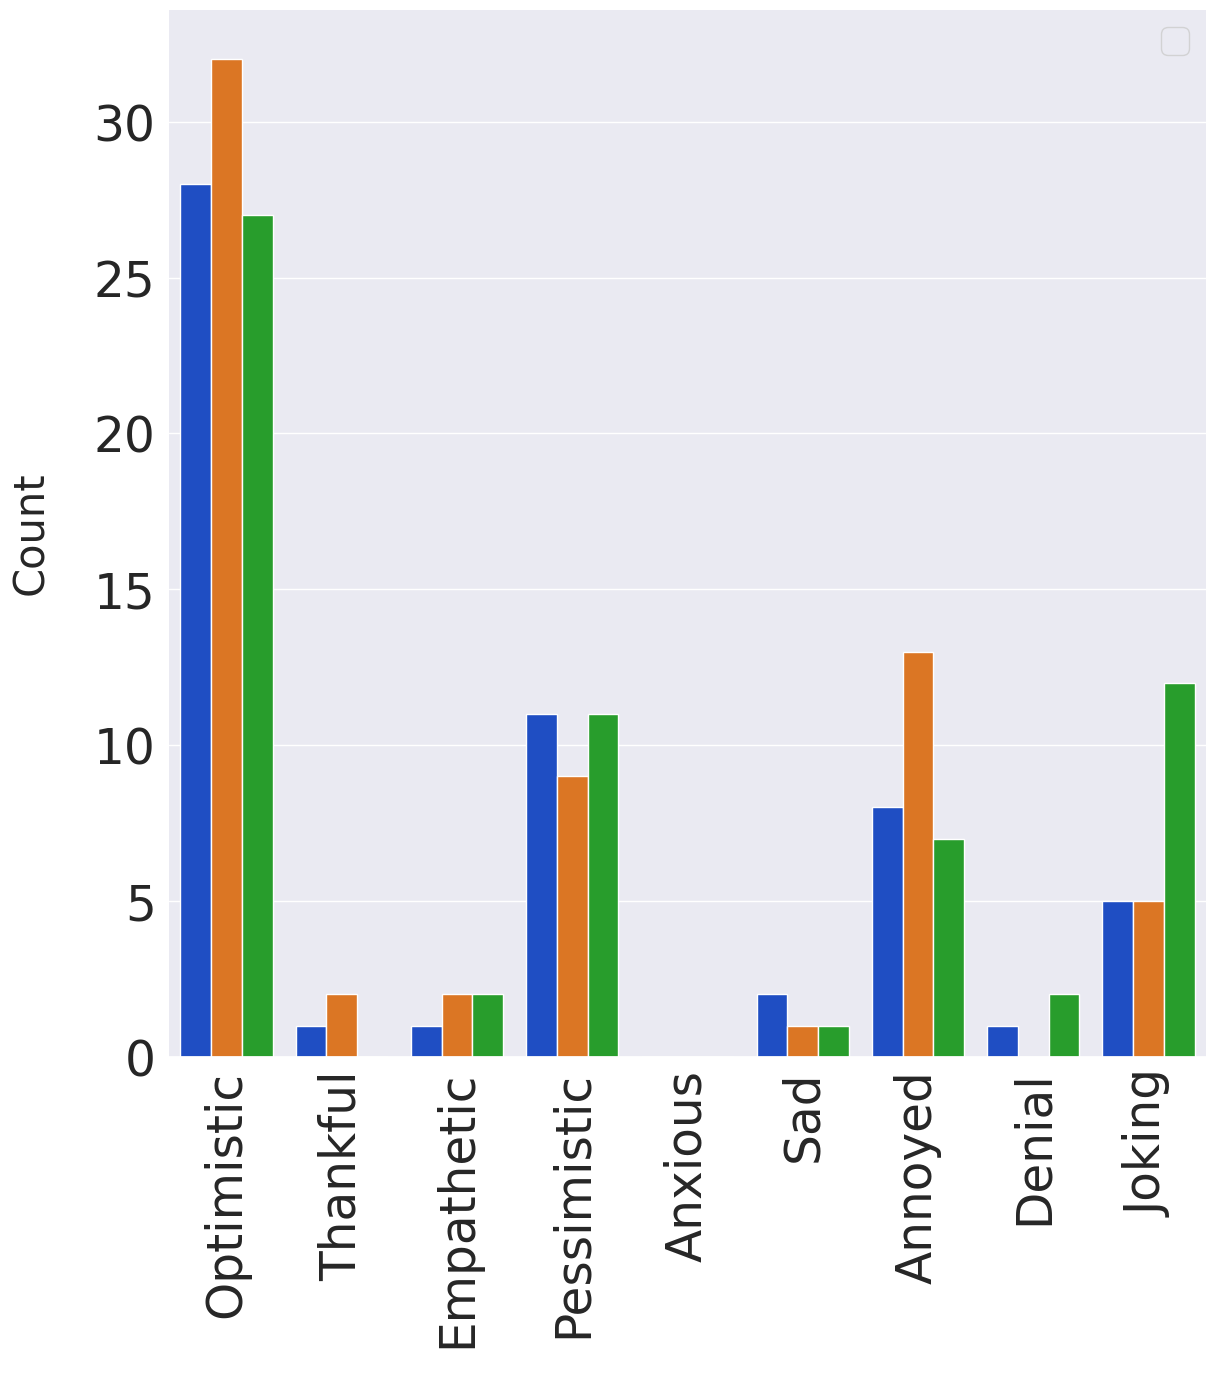

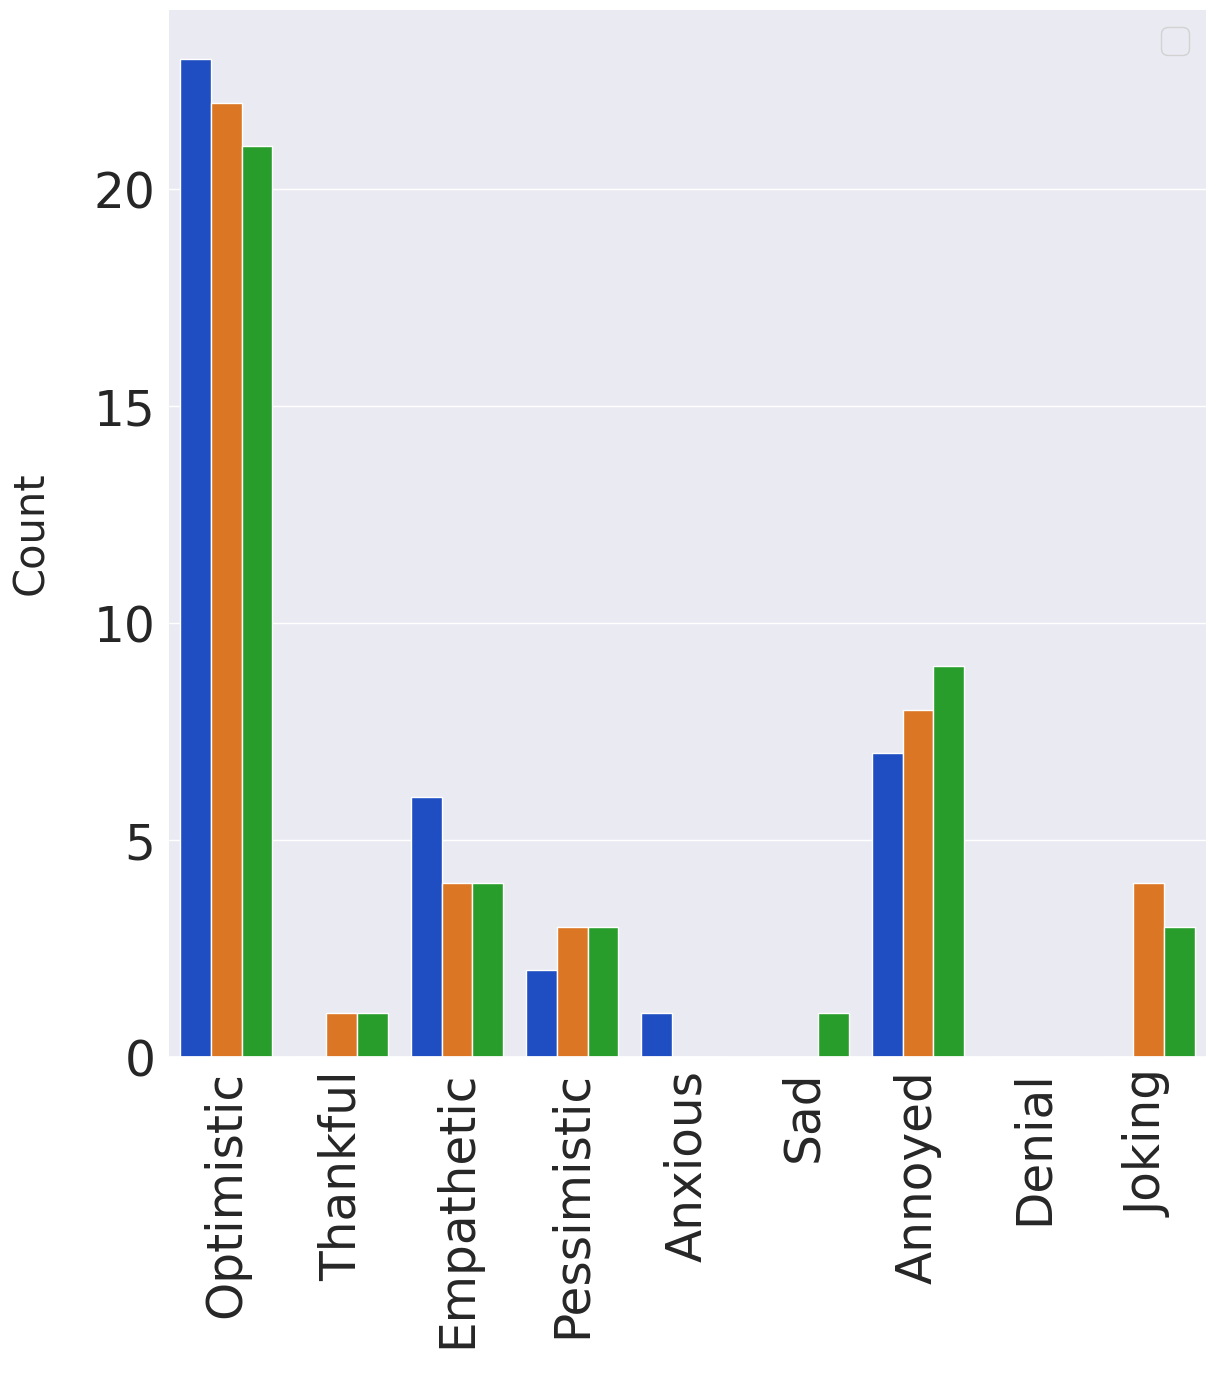

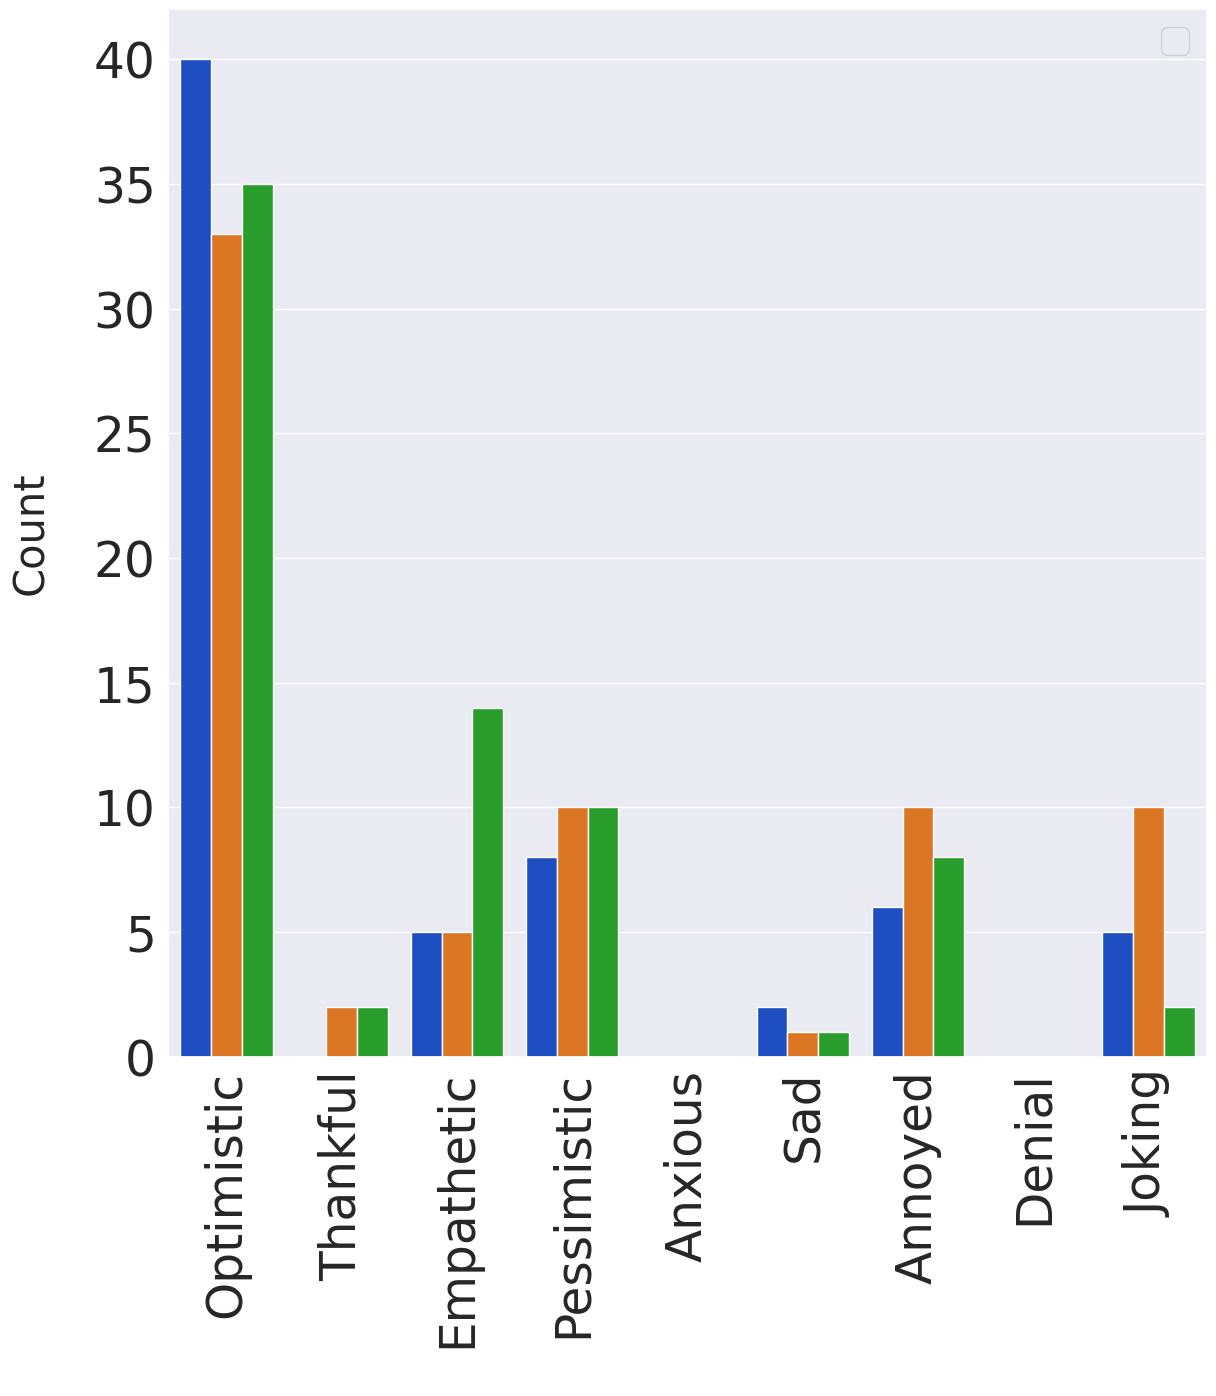

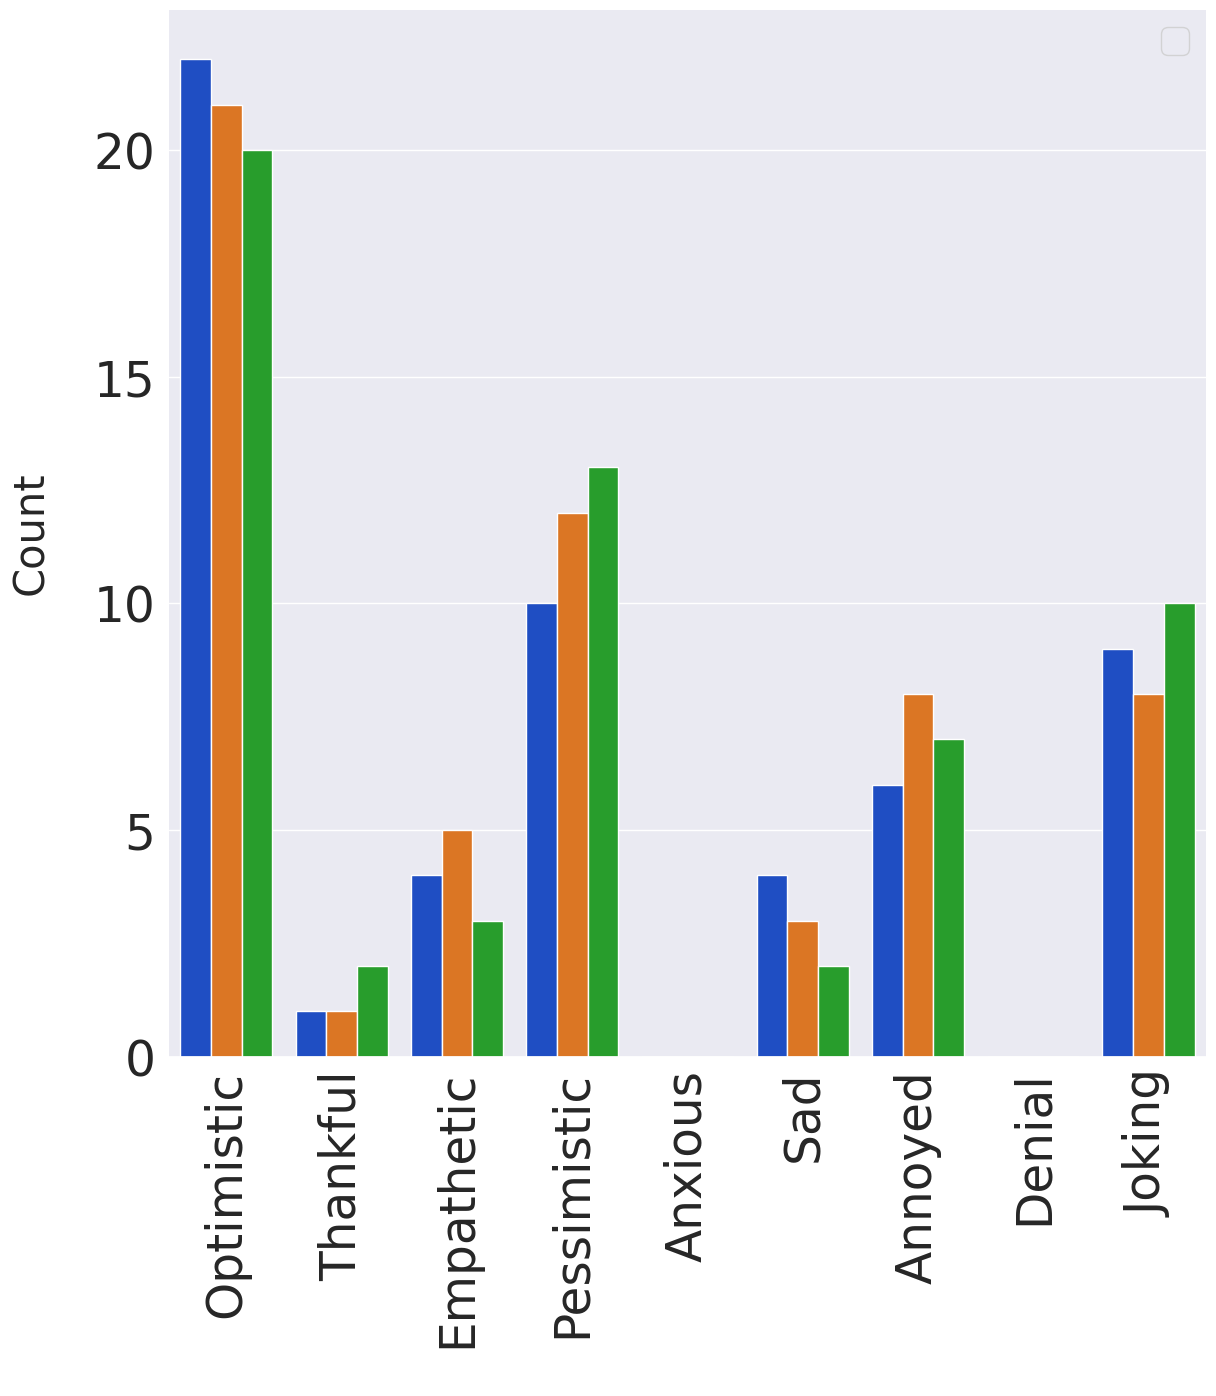

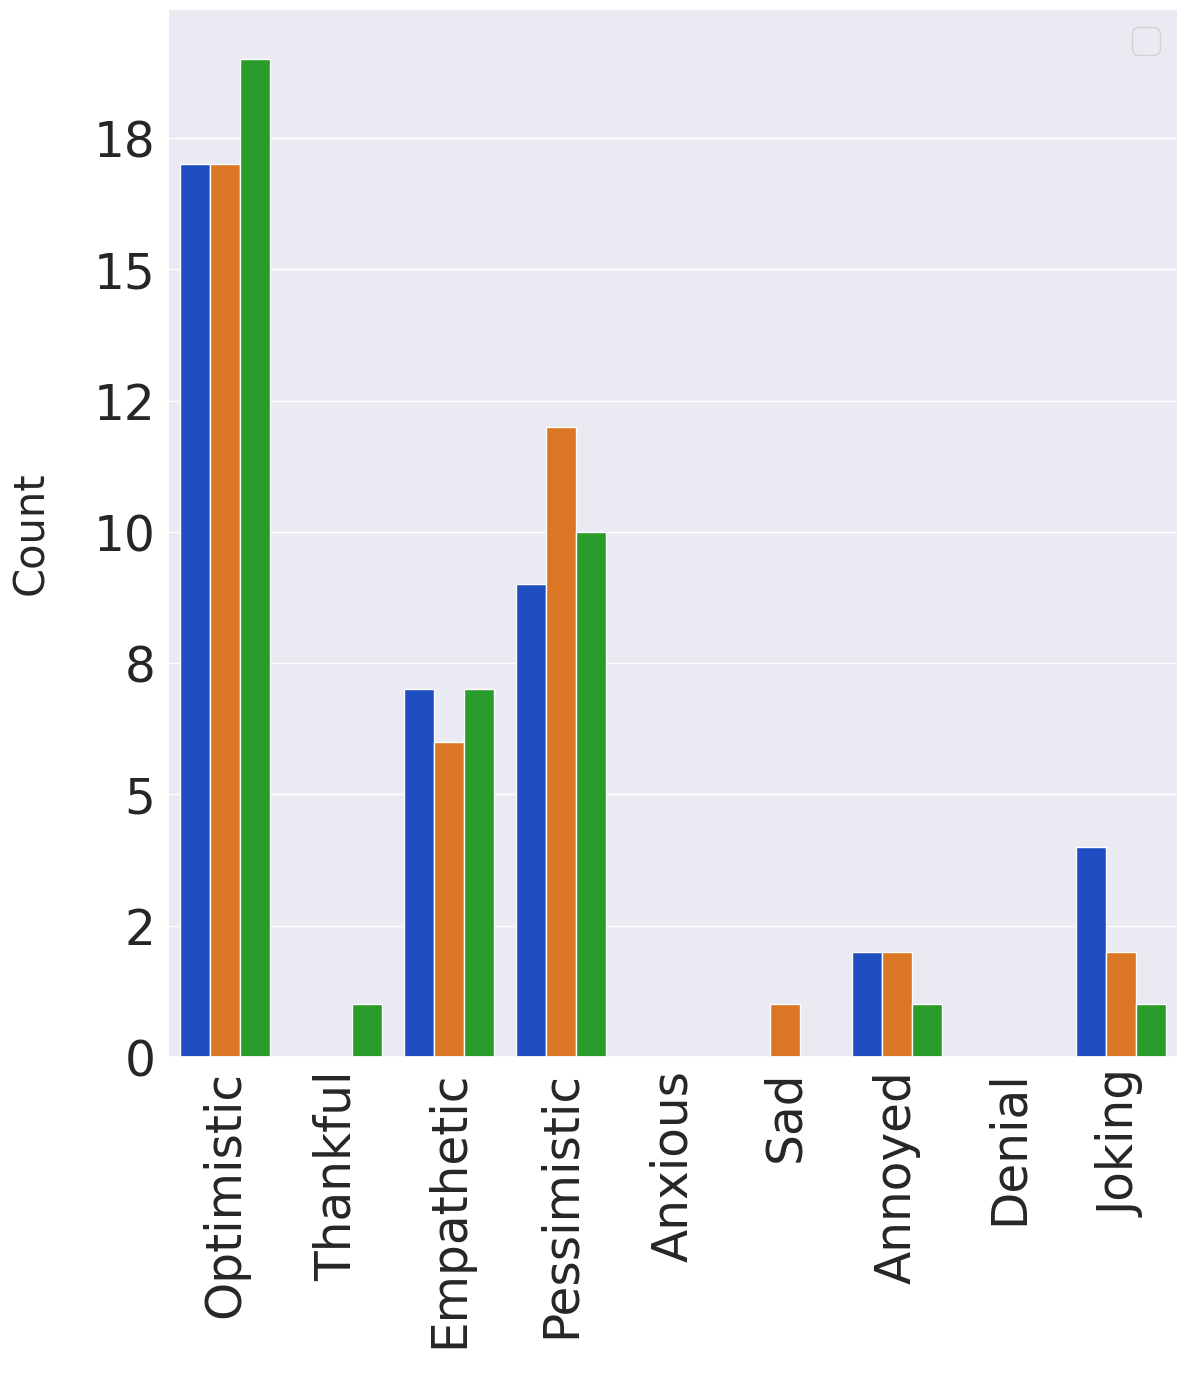

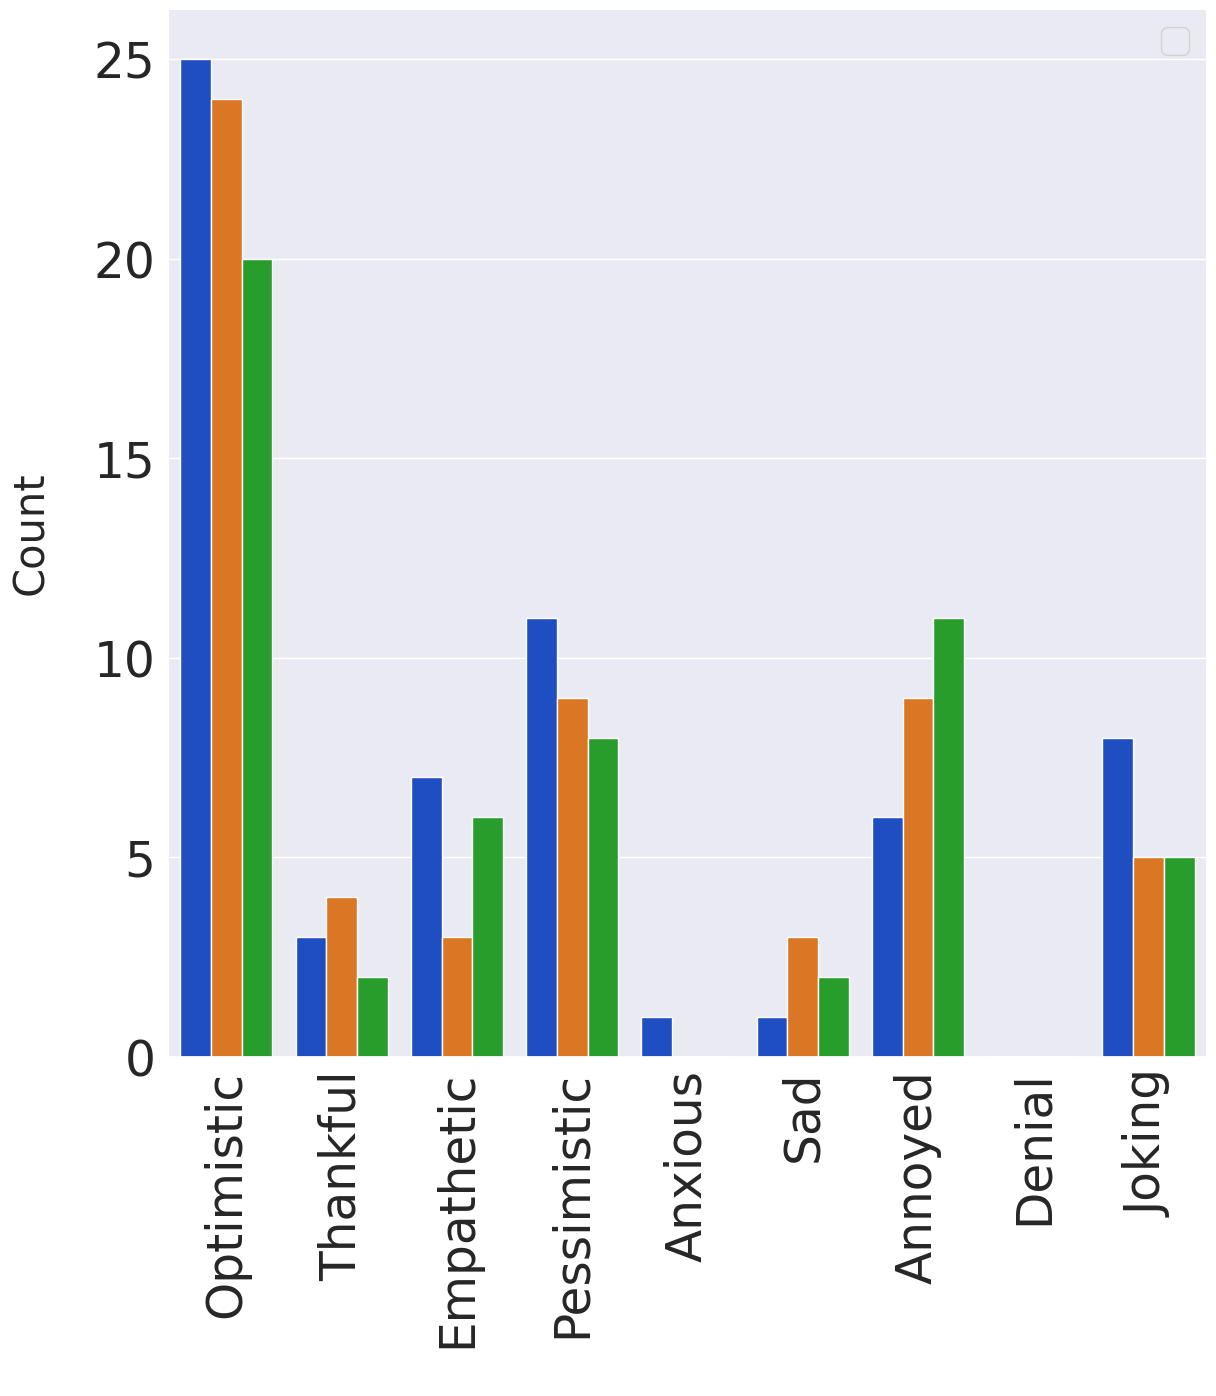

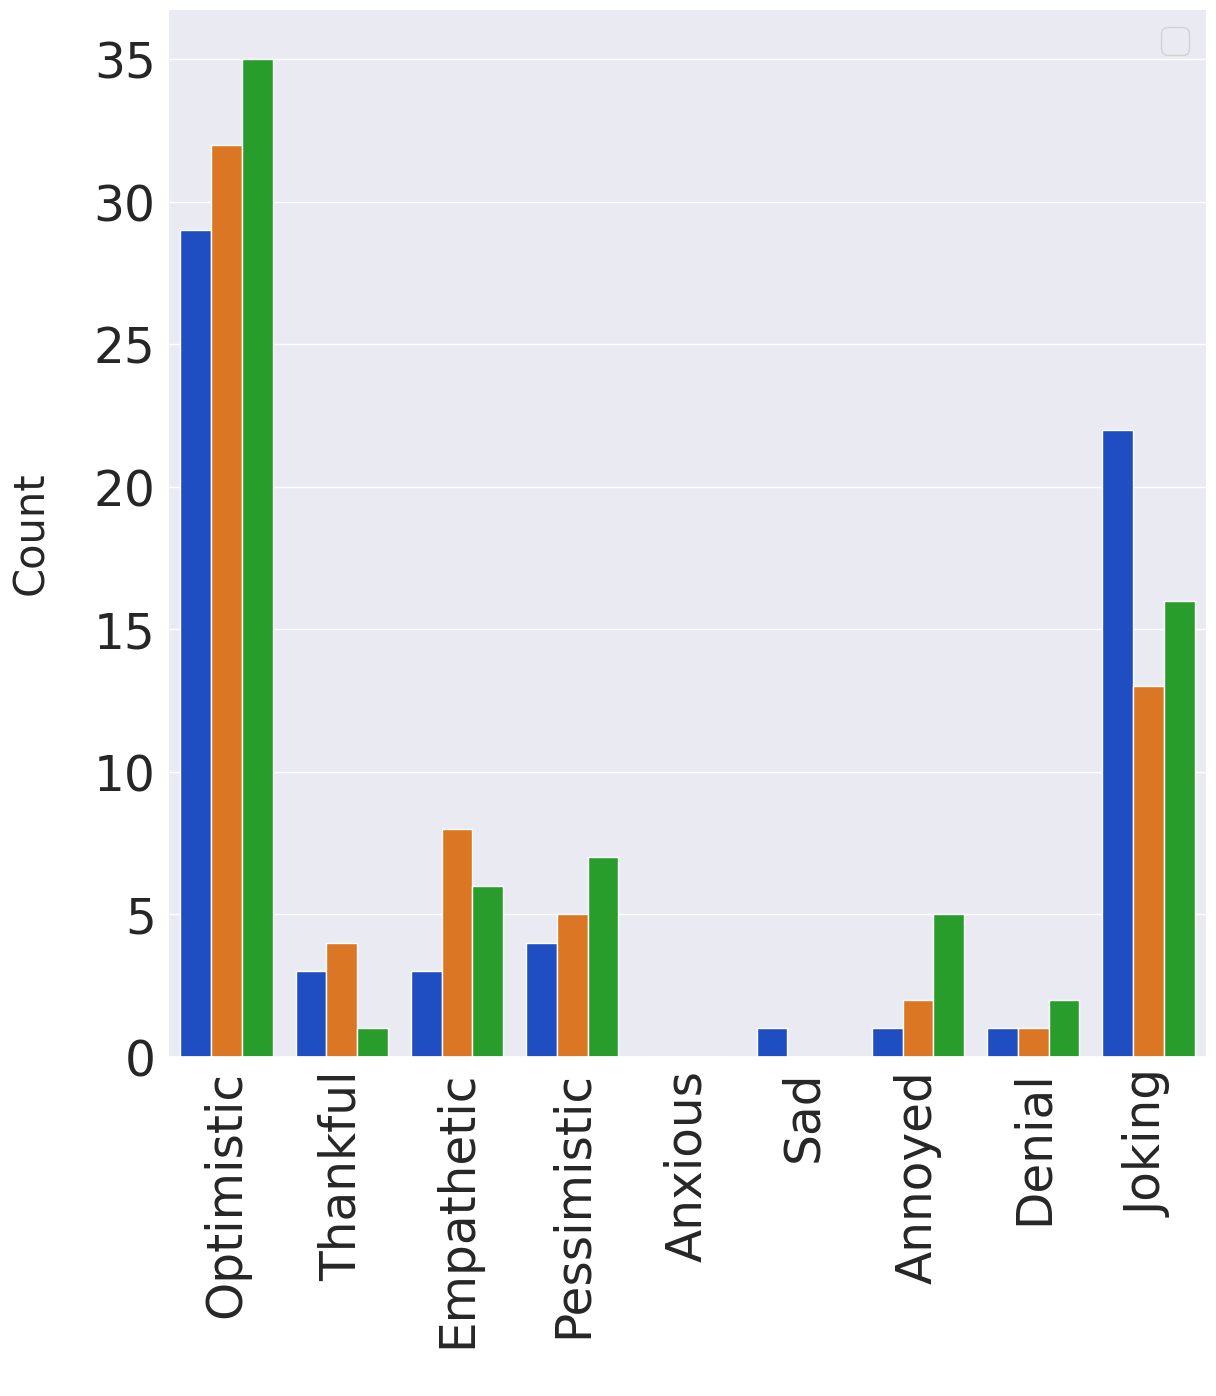

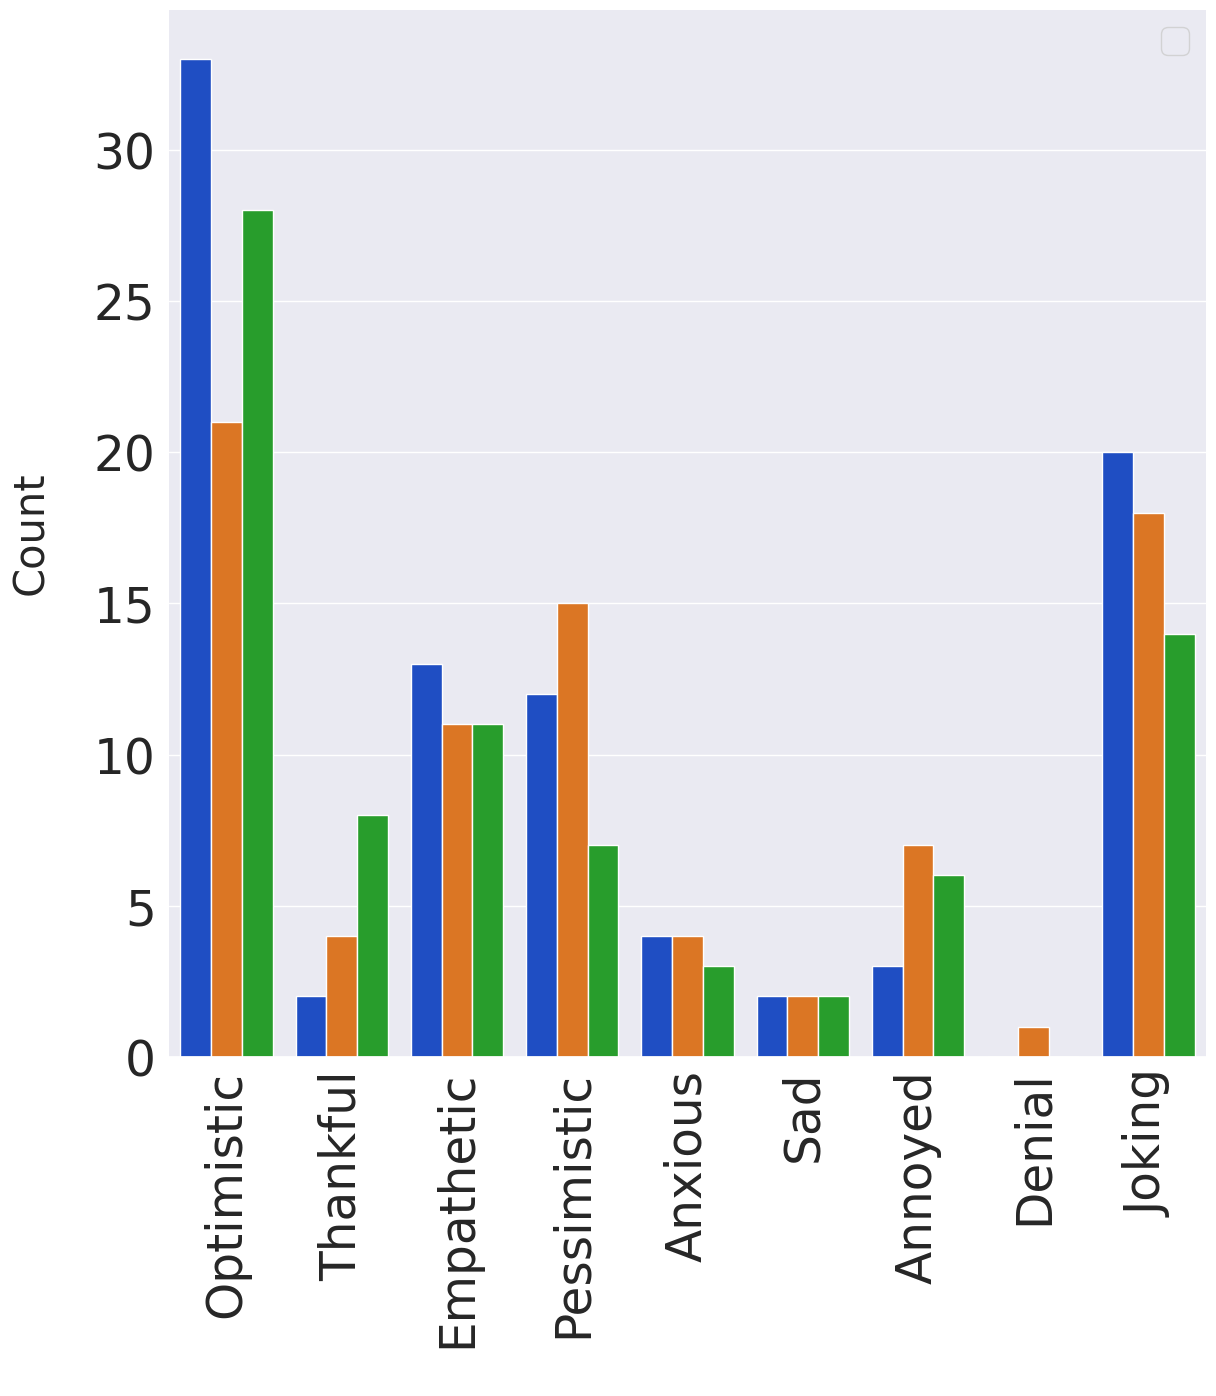

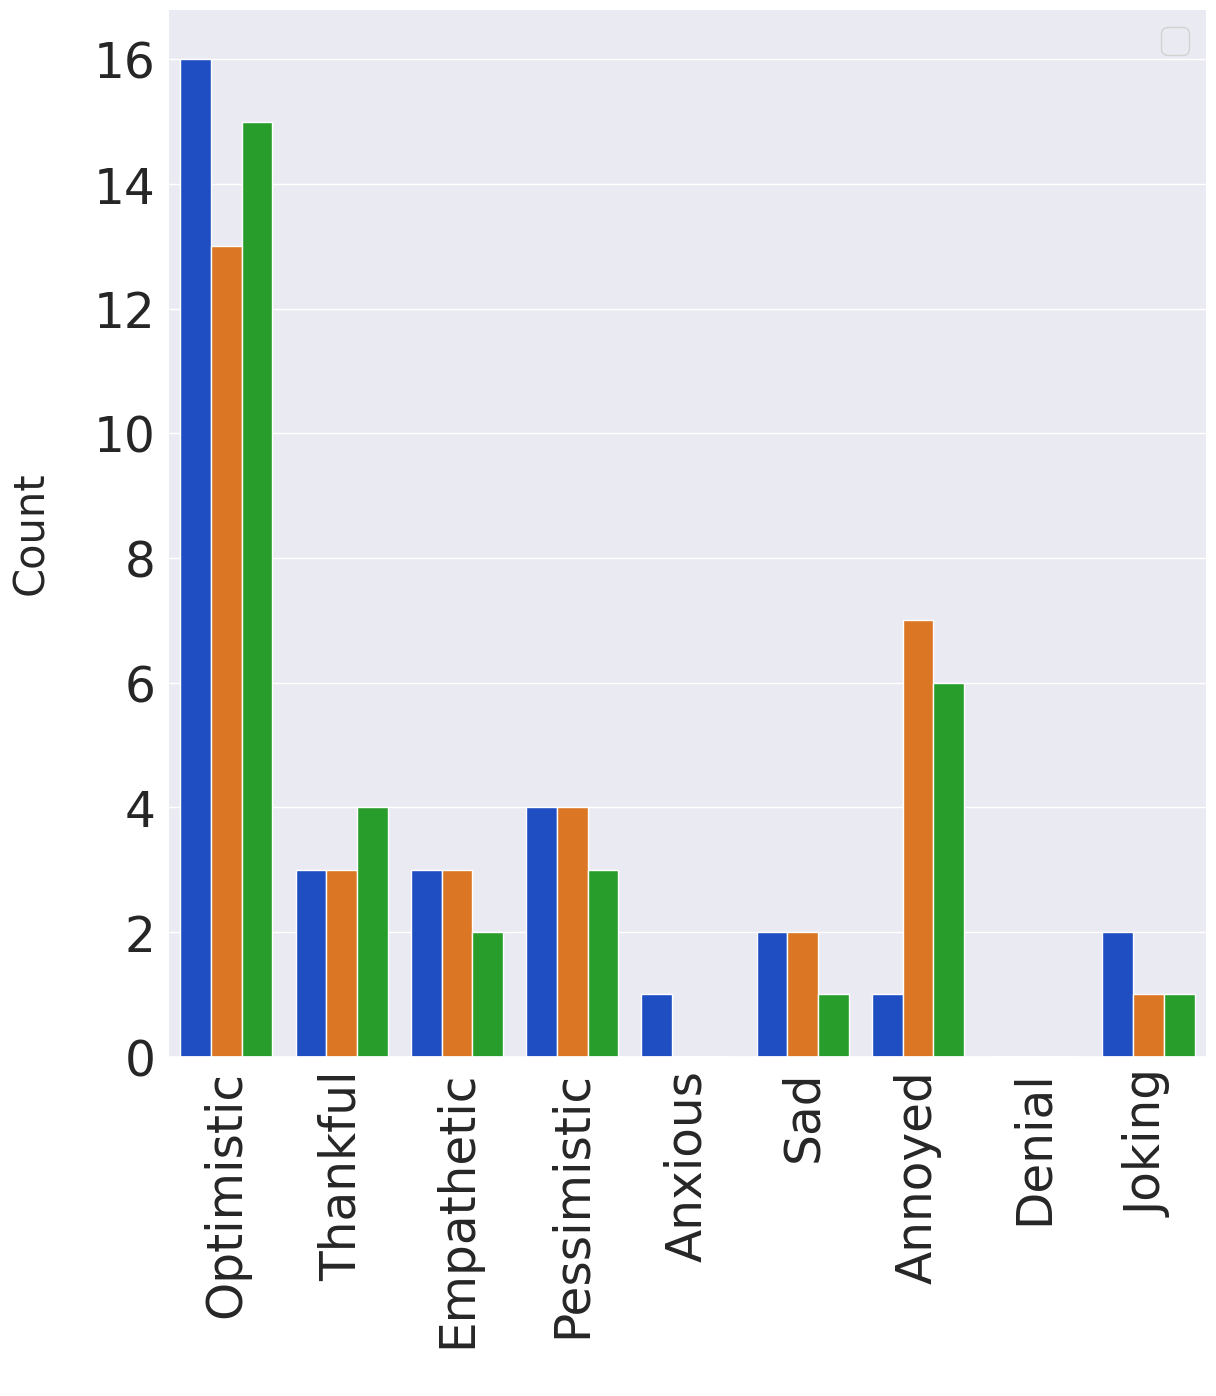

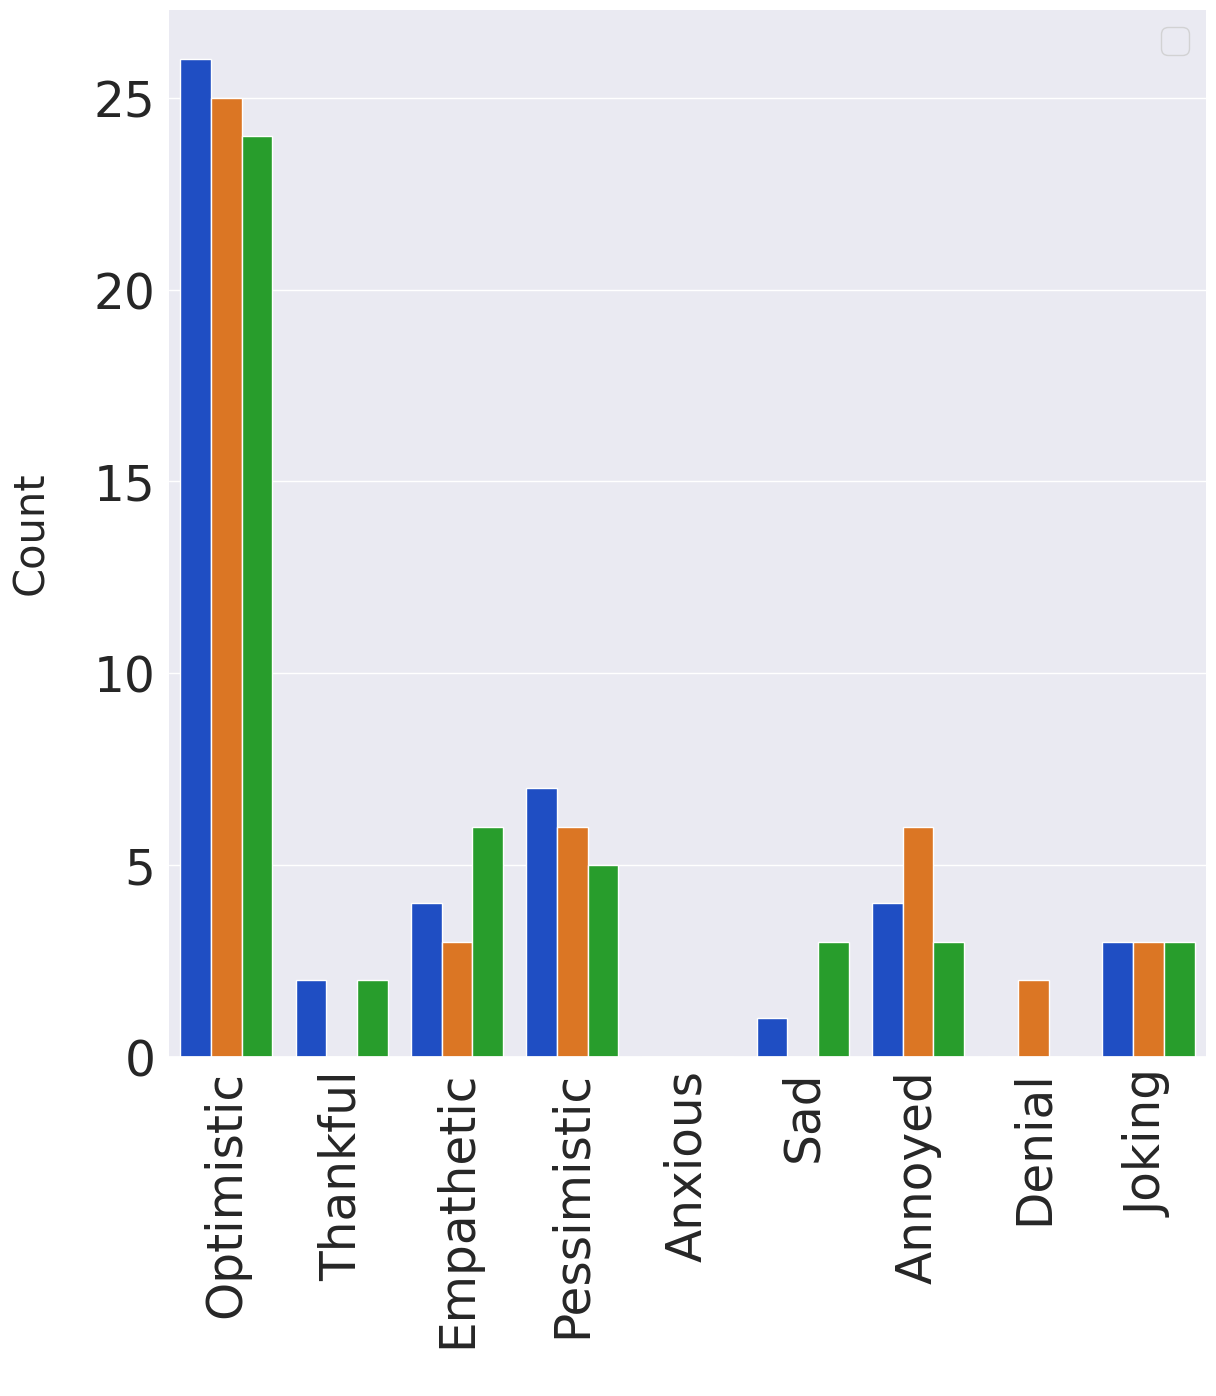

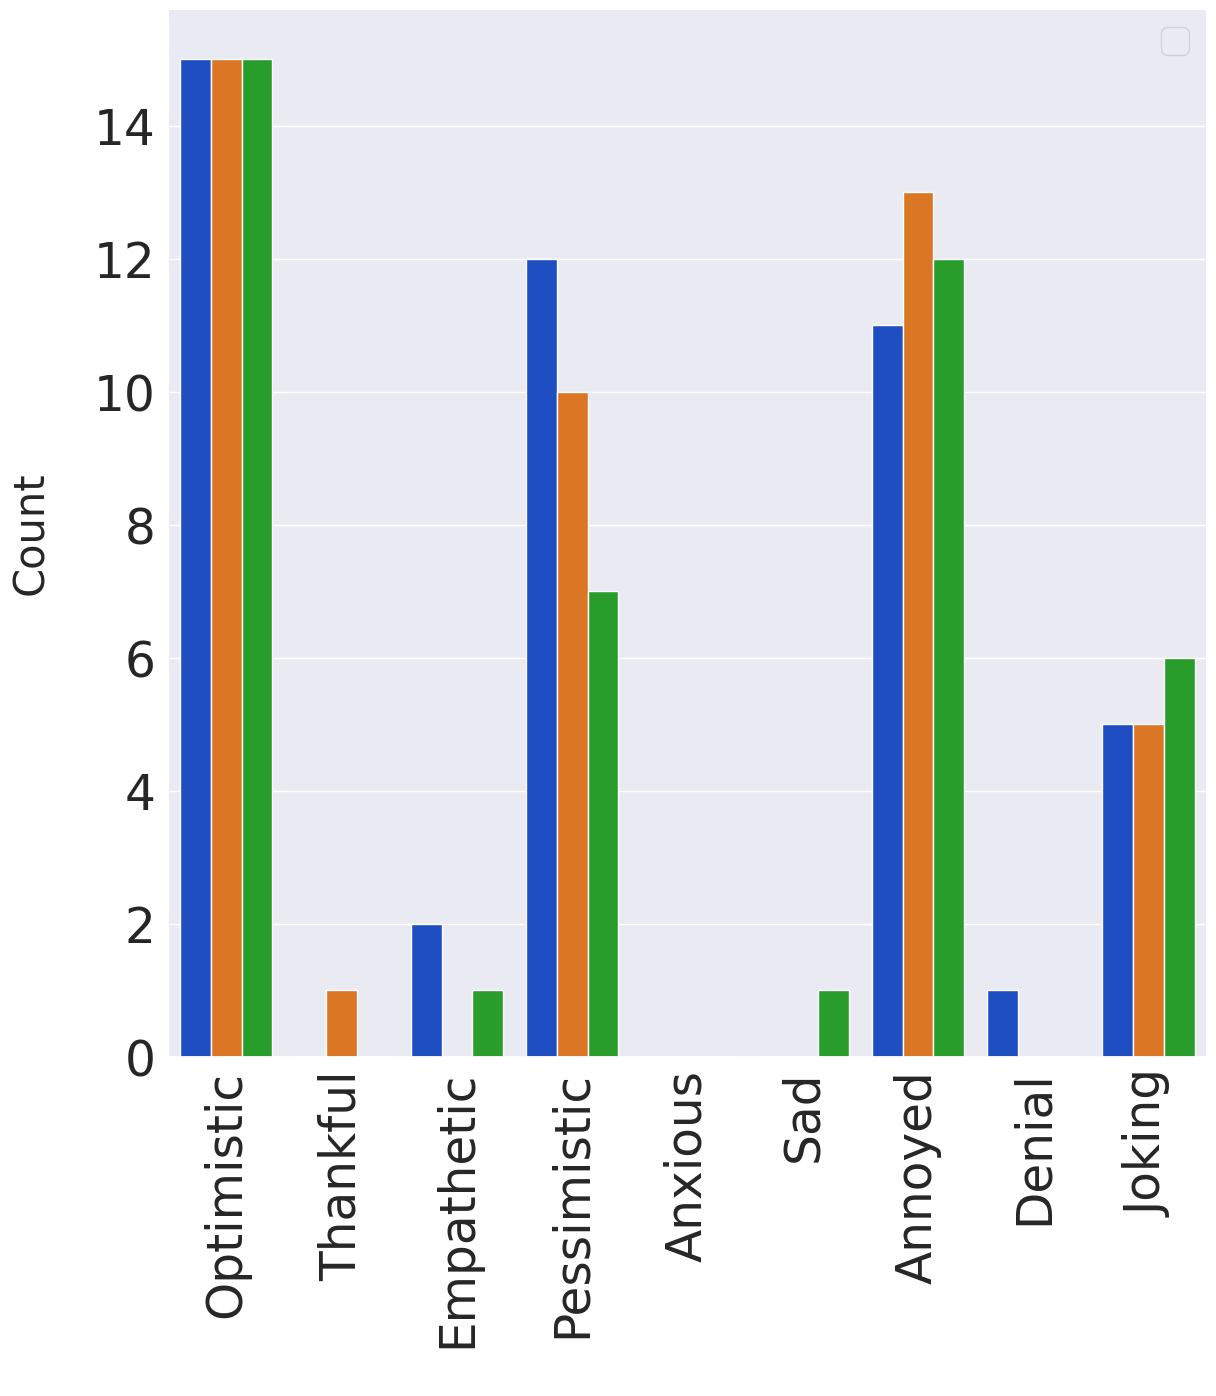

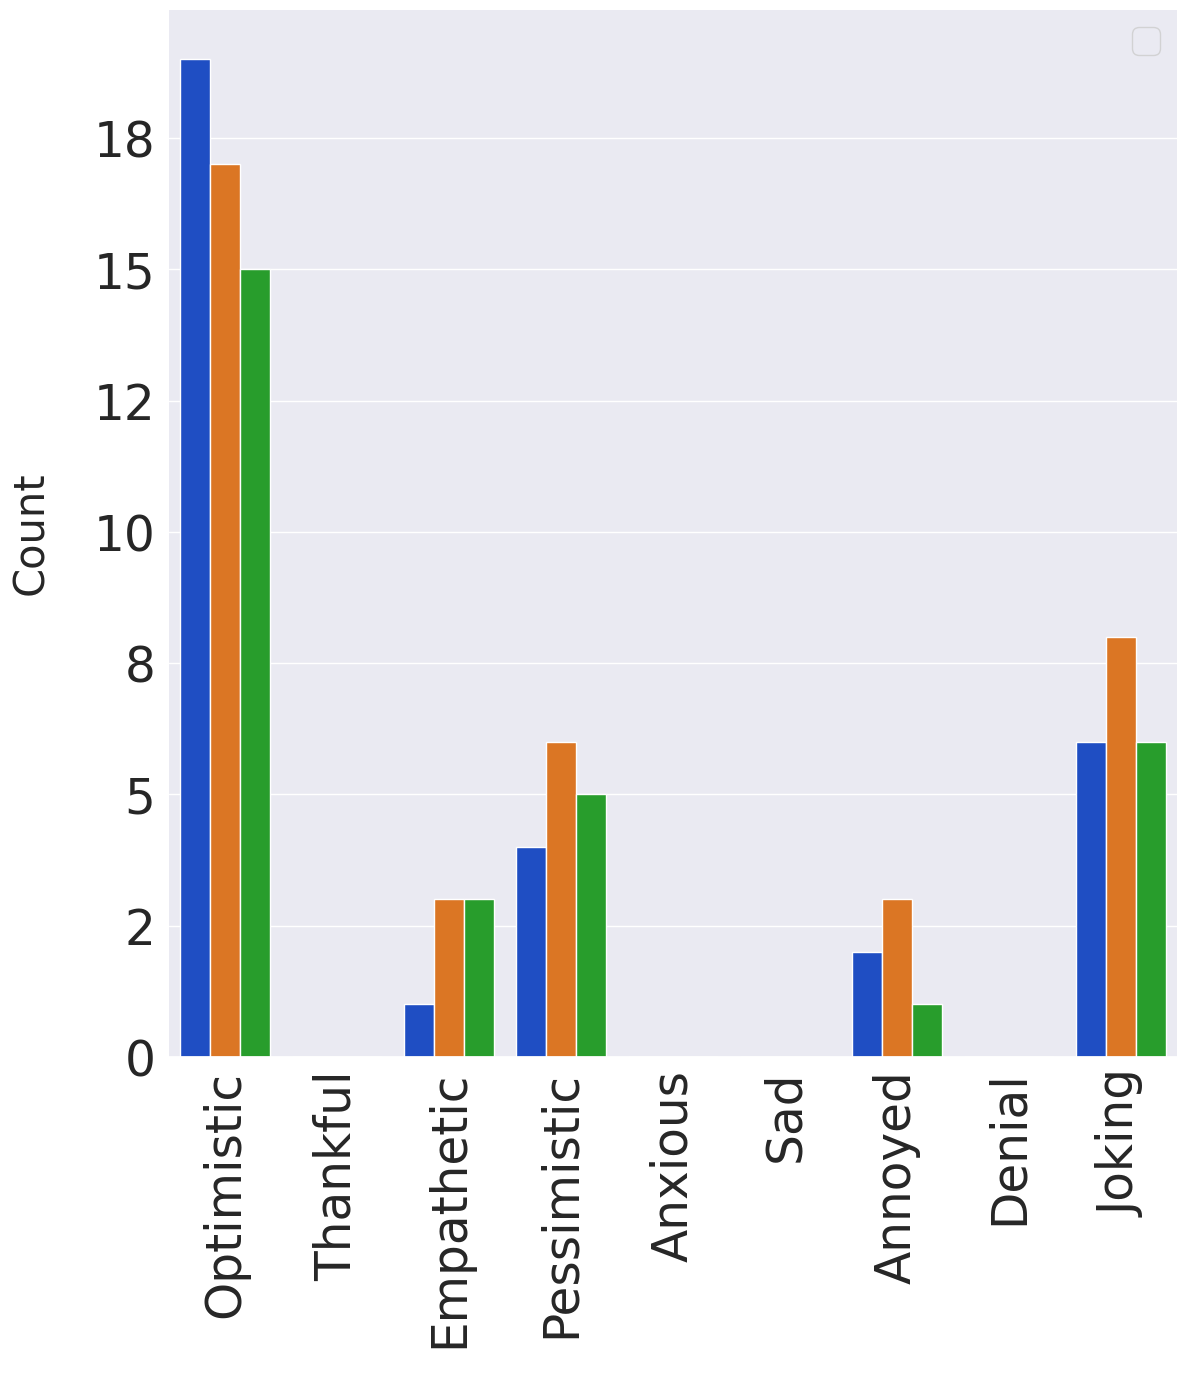

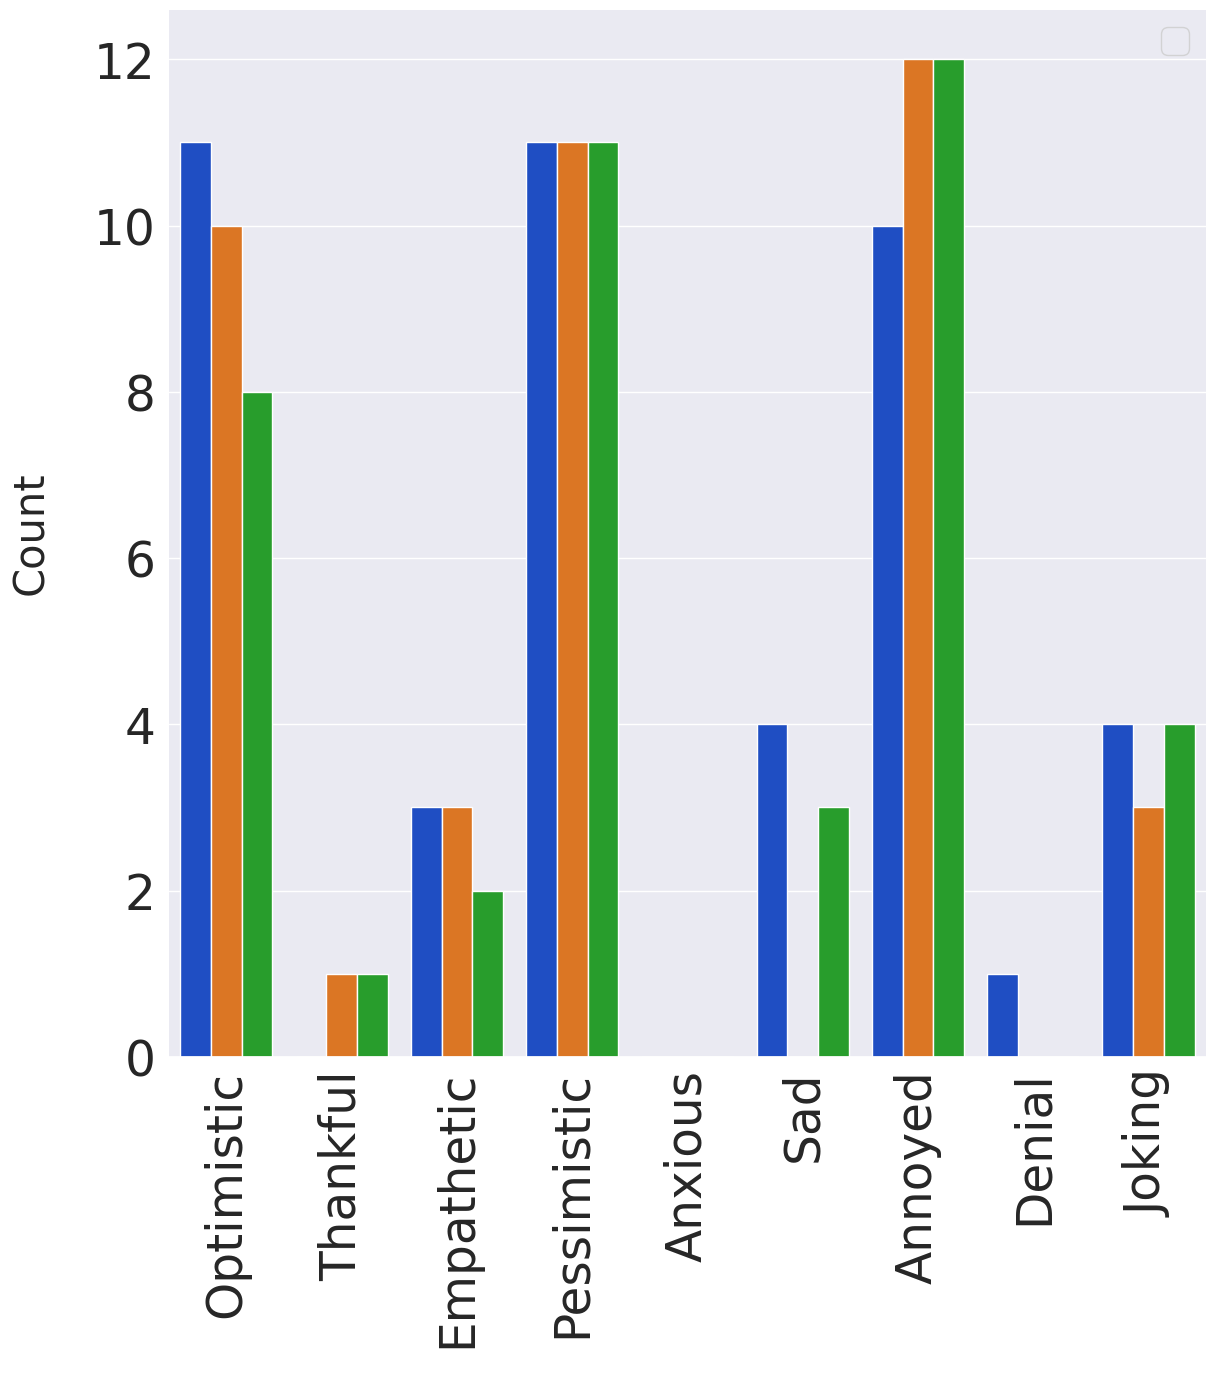

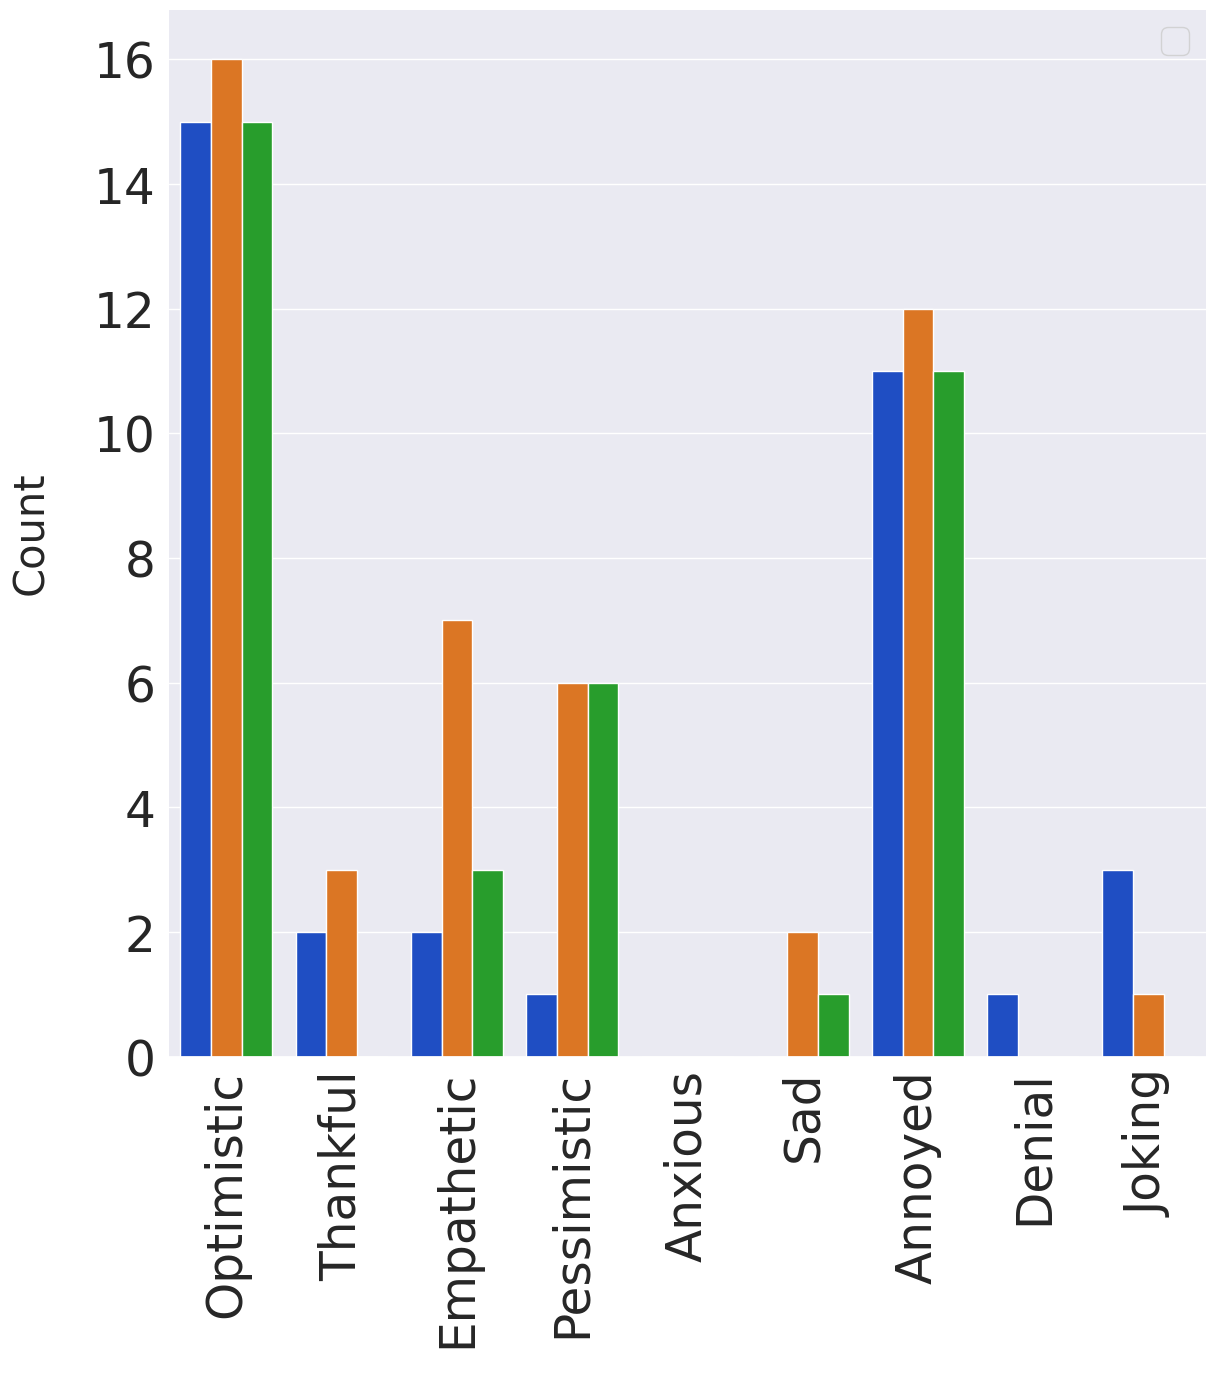

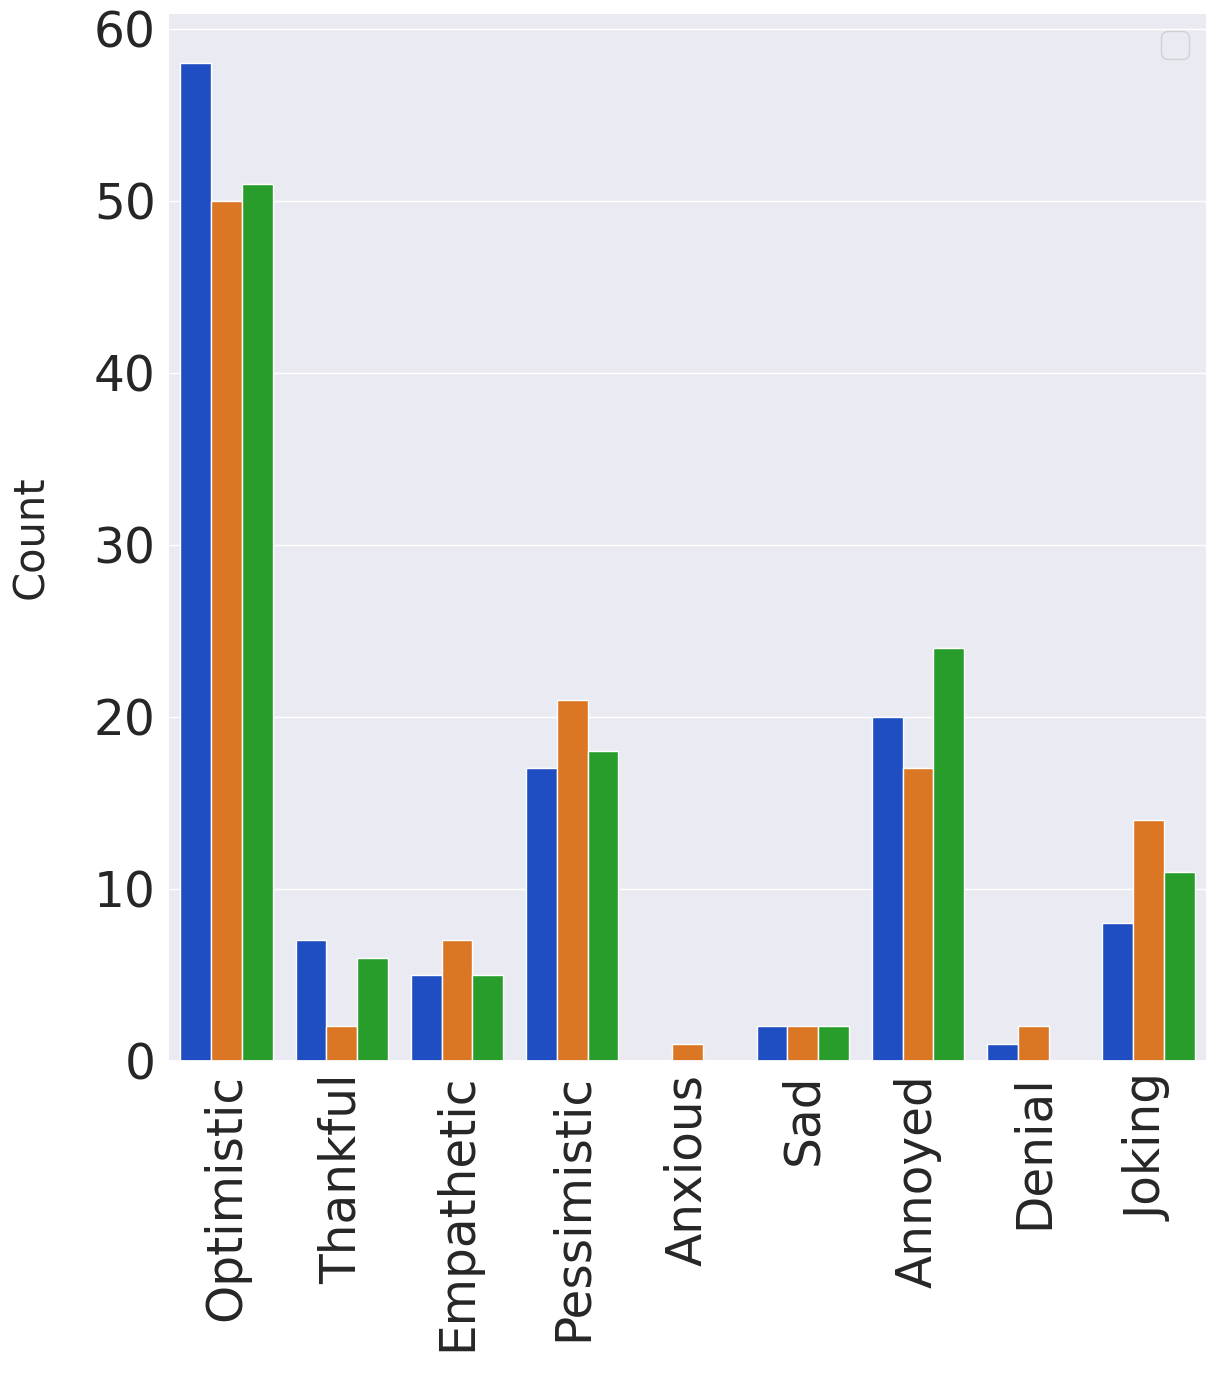

In [ ]:
for chapter in range(1,19):

  eknath_easwaran = chapter_wise_dataframe('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/eknatheaswaran/chapter ', chapter)
  mahatma_gandhi = chapter_wise_dataframe('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/mahatmagandhi/chapter ', chapter)
  purohit_swami = chapter_wise_dataframe('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/purohitswami/chapter ', chapter)

  df_new = pd.concat([eknath_easwaran, mahatma_gandhi['Count'], purohit_swami['Count']], axis=1)

  df_new.columns = ['Eknath Easwaran', 'Mahatma Gandhi', 'Purohit Swami']

  df_new = df_new.reset_index()

  df_new = df_new.rename(columns={"index":"Sentiment"})

  df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")

  colors = ["blue", "orange", "green"]
  myPalette = sns.xkcd_palette(colors)

  sns.set_style("darkgrid")
  g = sns.catplot(x='Sentiment', y='Count', hue='Author', data=df_new, kind='bar', height=12, palette = myPalette, legend=False)

  g.despine(left=True)

  # if chapter == 1 or chapter == 2 or chapter == 3 or chapter == 16 or chapter==17:
  #   plt.legend(loc='upper left',prop={"size":25})

  # else:
  #   plt.legend(loc='upper center',prop={"size":25})

  plt.legend(loc='best',prop={"size":25})

  plt.ylabel('Count', labelpad=30, fontsize=30)
  plt.xlabel(' ')

  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
  plt.yticks(fontsize= 35)
  plt.xticks(fontsize = 35)
  plt.xticks(rotation=90)



In [ ]:
df_new.head()

,Sentiment,Author,Count
0,Optimistic,Eknath Easwaran,58.0
1,Thankful,Eknath Easwaran,7.0
2,Empathetic,Eknath Easwaran,5.0
3,Pessimistic,Eknath Easwaran,17.0
4,Anxious,Eknath Easwaran,0.0


In [ ]:
df_new.reset_index()

,index,Sentiment,Author,Count
0,0,Optimistic,Eknath Easwaran,58.0
1,1,Thankful,Eknath Easwaran,7.0
2,2,Empathetic,Eknath Easwaran,5.0
3,3,Pessimistic,Eknath Easwaran,17.0
4,4,Anxious,Eknath Easwaran,0.0
5,5,Sad,Eknath Easwaran,2.0
6,6,Annoyed,Eknath Easwaran,20.0
7,7,Denial,Eknath Easwaran,1.0
8,8,Joking,Eknath Easwaran,8.0
9,9,Optimistic,Mahatma Gandhi,50.0


# HeatMaps

<Axes: >

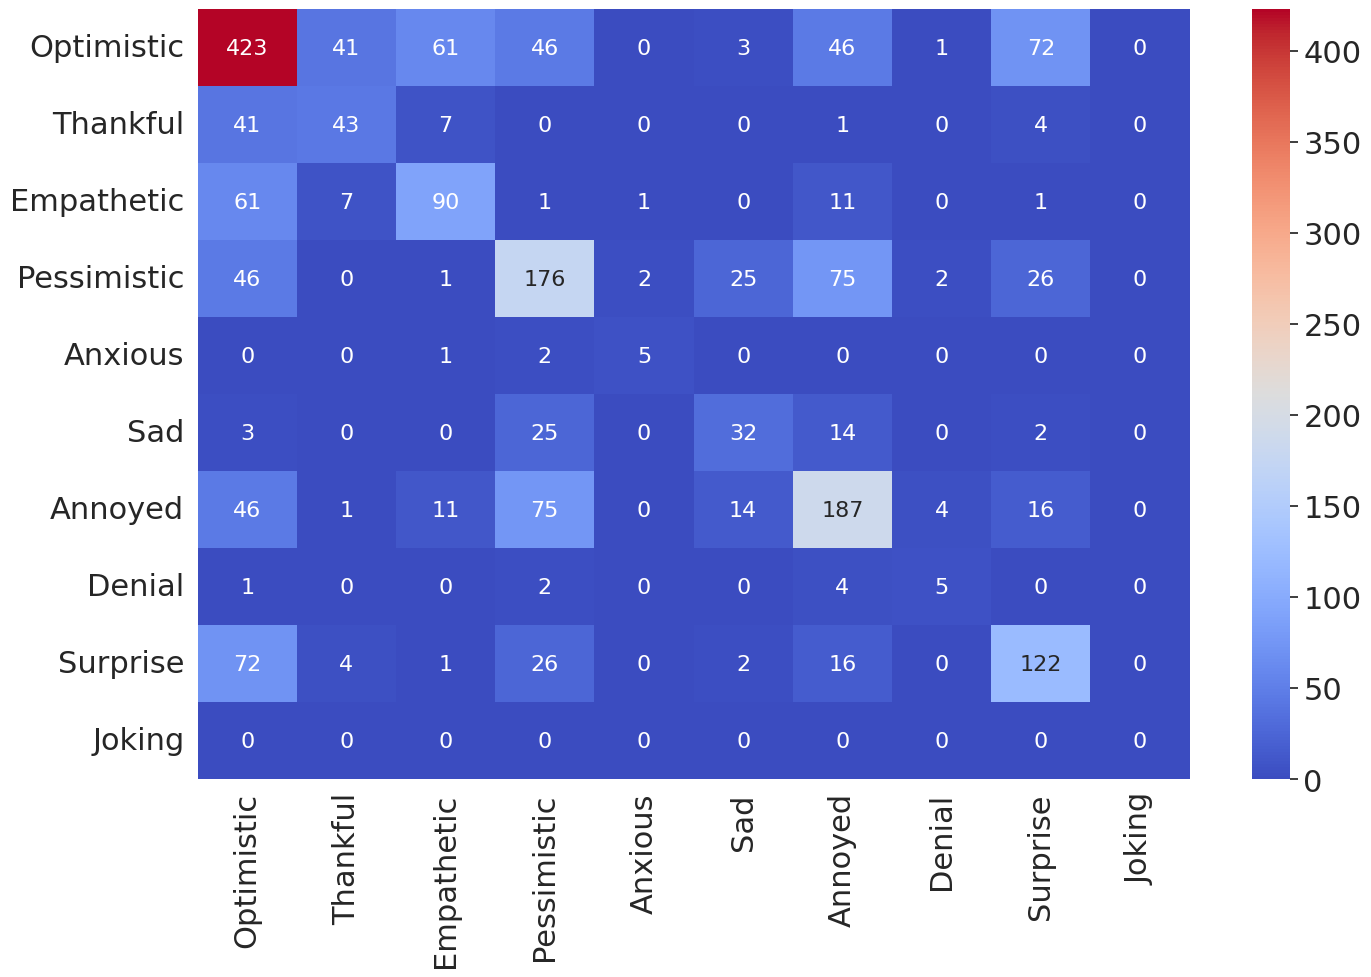

In [ ]:
heatmap_df = pd.read_csv('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/purohitswami/chapter 1.csv')
heatmap_df = heatmap_df.drop(['Tweet', 'Unnamed: 0','Official report'], axis=1)

for chapter in range(2, 19):
  df = pd.read_csv('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/purohitswami/chapter ' + str(chapter) + '.csv')

  df = df.drop(['Tweet', 'Unnamed: 0','Official report'], axis=1)

  heatmap_df = pd.concat([heatmap_df, df], axis=0)

emote_array = np.zeros((10, 10))
e2i = {
    'Optimistic' : 0, 'Thankful' : 1, 'Empathetic' : 2, 'Pessimistic' : 3, 'Anxious' : 4, 'Sad' : 5, 'Annoyed' : 6, 'Denial' : 7,
     'Joking' : 8
}

for i in range(len(heatmap_df)):
    l = heatmap_df.iloc[i].tolist()
    for j in range(9):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 9):                 # to avoid double counting.
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

emotions = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Surprise', 'Joking']

emote_df = pd.DataFrame(emote_array, columns = emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)

fig = plt.figure(figsize = (16, 10))
sns.set(font_scale=2)
sns.heatmap(emote_df, annot = True, cmap = 'coolwarm', xticklabels = emote_df.columns, yticklabels = emote_df.columns,
            fmt = 'g', annot_kws = {"size" : 16})
# plt.title('Chapter ' + str(chapter), pad = 25)

# Histplots

<Axes: xlabel='Sentiment', ylabel='Count'>

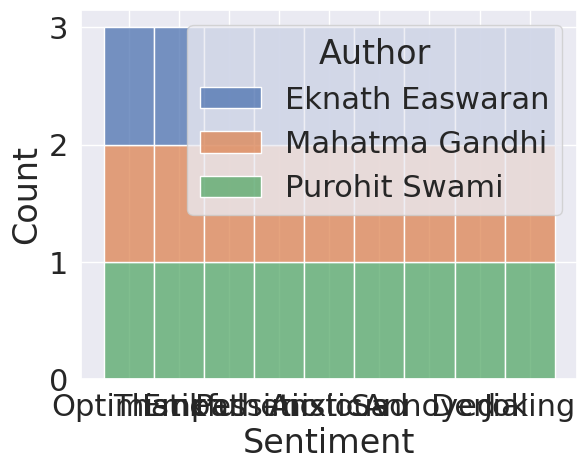

In [ ]:
eknath_easwaran = all_chapter_dataframe('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/eknatheaswaran/chapter ')
mahatma_gandhi = all_chapter_dataframe('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/mahatmagandhi/chapter ')
purohit_swami = all_chapter_dataframe('/content/drive/MyDrive/sbg_miniproject/outputs/sentimentanalysis/purohitswami/chapter ')

df_new = pd.concat([eknath_easwaran, mahatma_gandhi['Count'], purohit_swami['Count']], axis=1)

df_new.columns = ['Sentiment', 'Eknath Easwaran', 'Mahatma Gandhi', 'Purohit Swami']

df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")

sns.histplot(data= df_new, x='Sentiment', hue='Author', multiple= 'stack')

In [ ]:
df_new

,Sentiment,Author,Count
0,Optimistic,Eknath Easwaran,117
1,Thankful,Eknath Easwaran,138
2,Empathetic,Eknath Easwaran,130
3,Pessimistic,Eknath Easwaran,111
4,Anxious,Eknath Easwaran,124
5,Sad,Eknath Easwaran,121
6,Annoyed,Eknath Easwaran,119
7,Denial,Eknath Easwaran,82
8,Joking,Eknath Easwaran,0
9,Optimistic,Mahatma Gandhi,121


# Jaccard Similarity Score

In [ ]:
!pip install sklearn
from sklearn.metrics import jaccard_similarity_score, jaccard_score

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


ImportError: cannot import name 'jaccard_similarity_score' from 'sklearn.metrics' (/usr/local/lib/python3.10/dist-packages/sklearn/metrics/__init__.py)

In [ ]:
eknath_easwaran_chapter_one = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter 1')
mahatma_gandhi_chapter_one = pd.read_csv('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter 1')
purohit_swami_chapter_one = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter 1')

eknath_easwaran_chapter_1 = eknath_easwaran_chapter_one.drop(['Unnamed: 0', 'Tweet'], axis=1)
mahatma_gandhi_chapter_1 = mahatma_gandhi_chapter_one.drop(['Unnamed: 0', 'Tweet'], axis=1)
purohit_swami_chapter_1 = purohit_swami_chapter_one.drop(['Unnamed: 0', 'Tweet'], axis=1)

In [ ]:
row = eknath_easwaran_chapter_1.iloc[46, :]
row

Optimistic     0.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        0.0
Denial         0.0
Surprise       0.0
Joking         0.0
Name: 46, dtype: float64

In [ ]:
purohit_swami_chapter_1.iloc[46, :]

Optimistic     0.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        0.0
Denial         0.0
Surprise       0.0
Joking         0.0
Name: 46, dtype: float64

In [ ]:
eknath_easwaran_chapter_1

In [ ]:
import numpy as np
from sklearn.metrics import jaccard_score
y_true = np.array([[0, 1, 1],
                   [1, 1, 0]])
y_pred = np.array([[1, 1, 1],
                   [1, 0, 0]])

# jaccard_similarity_score(y_true, y_pred, normalize=False)



In [ ]:
for ii in range(0, eknath_easwaran_chapter_1.shape[0]):
  print(jaccard_score(eknath_easwaran_chapter_1.iloc[ii, :], purohit_swami_chapter_1.iloc[ii, :]))

Optimistic     0.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        1.0
Denial         0.0
Surprise       1.0
Joking         0.0
Name: 0, dtype: float64
Optimistic     0.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        0.0
Denial         0.0
Surprise       1.0
Joking         0.0
Name: 0, dtype: float64
0.5
Optimistic     0.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        0.0
Denial         0.0
Surprise       1.0
Joking         0.0
Name: 1, dtype: float64
Optimistic     0.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        0.0
Denial         0.0
Surprise       1.0
Joking         0.0
Name: 1, dtype: float64
1.0
Optimistic     1.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        0.0
Den

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_es_mg = pd.DataFrame()
df_es_ps = pd.DataFrame()
df_mg_ps = pd.DataFrame()

chapter_list = []
es_mg_list = []
es_ps_list = []
mg_ps_list = []

sum1 =0
sum2=0
sum3=0

for chapter in range(1, 19):

  if chapter==1 or chapter==2 or chapter==4 or chapter==6 or chapter==13 or chapter==14 or chapter==18:
    continue

  eknath_easwaran_chapter = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter ' + str(chapter))
  mahatma_gandhi_chapter = pd.read_csv('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter ' + str(chapter))
  purohit_swami_chapter = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter ' + str(chapter))

  eknath_easwaran_chapter = eknath_easwaran_chapter.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
  mahatma_gandhi_chapter = mahatma_gandhi_chapter.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
  purohit_swami_chapter = purohit_swami_chapter.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)

  for ii in range(0, eknath_easwaran_chapter.shape[0]):
    es_ps_list.append(jaccard_score(eknath_easwaran_chapter.iloc[ii, :], purohit_swami_chapter.iloc[ii, :]))
    es_mg_list.append(jaccard_score(eknath_easwaran_chapter.iloc[ii, :], mahatma_gandhi_chapter.iloc[ii, :]))
    mg_ps_list.append(jaccard_score(purohit_swami_chapter.iloc[ii, :], mahatma_gandhi_chapter.iloc[ii, :]))

  df_es_mg1 = pd.DataFrame(chapter_list, columns=['Chapter'])
  df_es_mg2 = pd.DataFrame(es_mg_list, columns=['Easwaran Gandhi'])
  df_es_mg = pd.concat([df_es_mg1, df_es_mg2], axis=1)
  # df_es_mg.to_csv('/content/drive/MyDrive/religious_texts/jaccard score of predicted sentiments/easwaran_gandhi/chapter ' + str(chapter) + '.csv')

  df_es_ps1 = pd.DataFrame(chapter_list, columns=['Chapter'])
  df_es_ps2 = pd.DataFrame(es_ps_list, columns=['Purohit Easwaran'])
  df_es_ps = pd.concat([df_es_ps1, df_es_ps2], axis=1)
  # df_es_ps.to_csv('/content/drive/MyDrive/religious_texts/jaccard score of predicted sentiments/purohit_easwaran/chapter ' + str(chapter) + '.csv')

  df_mg_ps1 = pd.DataFrame(chapter_list, columns=['Chapter'])
  df_mg_ps2 = pd.DataFrame(mg_ps_list, columns=['Purohit Gandhi'])
  df_mg_ps = pd.concat([df_mg_ps1, df_mg_ps2], axis=1)
  # df_mg_ps.to_csv('/content/drive/MyDrive/religious_texts/jaccard score of predicted sentiments/gandhi_purohit/chapter ' + str(chapter) + '.csv')

  print('Chapter ', str(chapter), ' Average')

  print('Easwaran Gandhi ', df_es_mg['Easwaran Gandhi'].mean())
  print('Easwaran Purohit Swami ', df_es_ps['Purohit Easwaran'].mean())
  print('Purohit Swami and Gandhi ', df_mg_ps['Purohit Gandhi'].mean())

  print('\n')

  sum1+=df_es_mg['Easwaran Gandhi'].mean()
  sum2+=df_es_ps['Purohit Easwaran'].mean()
  sum3+=df_mg_ps['Purohit Gandhi'].mean()


Chapter  3  Average
Easwaran Gandhi  0.6042635658914729
Easwaran Purohit Swami  0.5058139534883719
Purohit Swami and Gandhi  0.683720930232558


Chapter  5  Average
Easwaran Gandhi  0.5680555555555556
Easwaran Purohit Swami  0.5196759259259258
Purohit Swami and Gandhi  0.6143518518518519


Chapter  7  Average
Easwaran Gandhi  0.5589869281045753
Easwaran Purohit Swami  0.4885620915032679
Purohit Swami and Gandhi  0.5736928104575166


Chapter  8  Average
Easwaran Gandhi  0.5469230769230767
Easwaran Purohit Swami  0.503205128205128
Purohit Swami and Gandhi  0.5680769230769234


Chapter  9  Average
Easwaran Gandhi  0.5013211382113819
Easwaran Purohit Swami  0.485772357723577
Purohit Swami and Gandhi  0.5647357723577238


Chapter  10  Average
Easwaran Gandhi  0.523462783171521
Easwaran Purohit Swami  0.5068770226537217
Purohit Swami and Gandhi  0.5624595469255665


Chapter  11  Average
Easwaran Gandhi  0.5071519795657725
Easwaran Purohit Swami  0.48780332056194114
Purohit Swami and Gandhi  

In [ ]:
sum1 = sum1/11
sum2 = sum2/11
sum3 = sum3/11

print('sum1 ', sum1)
print('sum2 ', sum2)
print('sum3 ', sum3)

sum1  0.5285112503502581
sum2  0.49698301709817033
sum3  0.562929633367387


In [ ]:
df_es_mg1 = pd.DataFrame(chapter_list, columns=['Chapter'])
df_es_mg2 = pd.DataFrame(es_mg_list, columns=['Easwaran Gandhi'])

df_es_mg = pd.concat([df_es_mg1, df_es_mg2], axis=1)

df_es_mg

,Chapter,Easwaran Gandhi
0,3,0.268939
1,5,0.161314
2,7,0.320545
3,8,0.199410
4,9,0.147005
5,10,0.260891
6,11,0.254790
7,12,0.152810
8,15,0.175292
9,16,0.327742


In [ ]:
df_es_ps1 = pd.DataFrame(chapter_list, columns=['Chapter'])
df_es_ps2 = pd.DataFrame(es_ps_list, columns=['Purohit Easwaran'])

df_es_ps = pd.concat([df_es_ps1, df_es_ps2], axis=1)

df_es_ps

,Chapter,Purohit Easwaran
0,3,0.178569
1,5,0.175086
2,7,0.293483
3,8,0.246212
4,9,0.192998
5,10,0.301439
6,11,0.228807
7,12,0.217280
8,15,0.245130
9,16,0.248018


In [ ]:
df_mg_ps1 = pd.DataFrame(chapter_list, columns=['Chapter'])
df_mg_ps2 = pd.DataFrame(mg_ps_list, columns=['Purohit Gandhi'])

df_mg_ps = pd.concat([df_mg_ps1, df_mg_ps2], axis=1)

df_mg_ps

,Chapter,Purohit Gandhi
0,3,0.261287
1,5,0.192829
2,7,0.348747
3,8,0.236015
4,9,0.324199
5,10,0.278529
6,11,0.198403
7,12,0.265634
8,15,0.243561
9,16,0.330628


In [ ]:
df_final = pd.concat([df_es_mg, df_es_ps['Purohit Easwaran'], df_mg_ps['Purohit Gandhi']], axis=1)

df_final



,Chapter,Easwaran Gandhi,Purohit Easwaran,Purohit Gandhi
0,3,0.268939,0.178569,0.261287
1,5,0.161314,0.175086,0.192829
2,7,0.320545,0.293483,0.348747
3,8,0.199410,0.246212,0.236015
4,9,0.147005,0.192998,0.324199
5,10,0.260891,0.301439,0.278529
6,11,0.254790,0.228807,0.198403
7,12,0.152810,0.217280,0.265634
8,15,0.175292,0.245130,0.243561
9,16,0.327742,0.248018,0.330628


In [ ]:
Easwaran_Gandhi_avg_score = df_final['Easwaran Gandhi'].mean()
Purohit_Easwaran_avg_score = df_final['Purohit Easwaran'].mean()
Purohit_Gandhi_avg_score = df_final['Purohit Gandhi'].mean()

print(Easwaran_Gandhi_avg_score)
print(Purohit_Easwaran_avg_score)
print(Purohit_Gandhi_avg_score)

0.22959057724175366
0.22867606818725064
0.26680619747400475


In [ ]:
data=pd.melt(df_final, ['Chapter'])

In [ ]:
data

,Chapter,variable,value
0,3,Easwaran Gandhi,0.268939
1,5,Easwaran Gandhi,0.161314
2,7,Easwaran Gandhi,0.320545
3,8,Easwaran Gandhi,0.199410
4,9,Easwaran Gandhi,0.147005
5,10,Easwaran Gandhi,0.260891
6,11,Easwaran Gandhi,0.254790
7,12,Easwaran Gandhi,0.152810
8,15,Easwaran Gandhi,0.175292
9,16,Easwaran Gandhi,0.327742


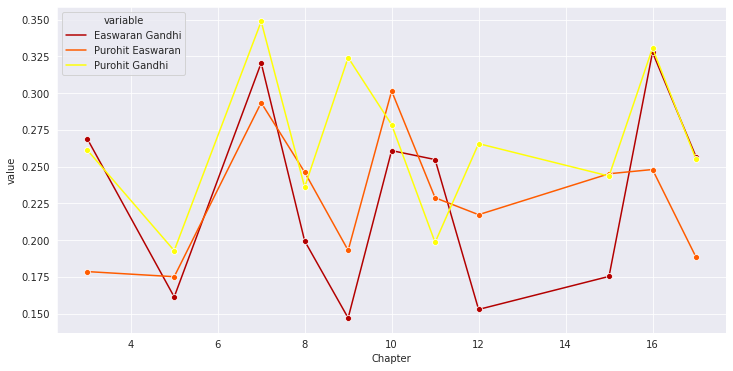

In [ ]:

sns.set_style("darkgrid")

fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.lineplot(x='Chapter', y='value', hue='variable', data=data, ax = ax)

sns.lineplot(x='Chapter',y='value',  hue = 'variable', data=data,
             palette = 'hot', dashes= False, marker= 'o', ax=ax)

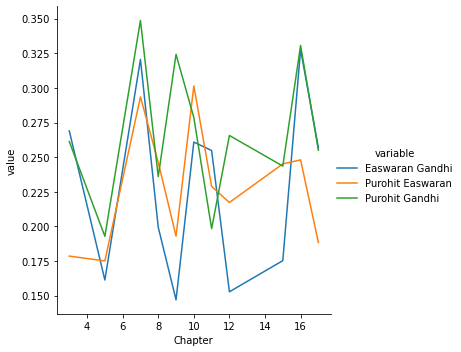

In [ ]:
sns.relplot(x="Chapter", y="value", hue="variable",
            dashes=False, markers=True, kind="line", data=data)

# Analyzing classification of Sentiments (experimentation)

In [ ]:
df_chapter_12 = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter 12')
df_chapter_12.drop(['Unnamed: 0', 'Official report'], axis=1, inplace=True)


In [ ]:
df_gandhi_chapter_12 = pd.read_csv('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter 12')

In [ ]:
df_chapter_12_optimistic = df_chapter_12.loc[(df_chapter_12['Optimistic'] == 1)]
df_chapter_12_annoyed = df_chapter_12.loc[(df_chapter_12['Annoyed'] == 1)]

df_chapter_12_annoyed

In [ ]:
df_chapter_12_optimistic_gandhi = df_gandhi_chapter_12.loc[(df_gandhi_chapter_12['Optimistic'] == 1)]
df_chapter_12_annoyed_gandhi = df_gandhi_chapter_12.loc[(df_gandhi_chapter_12['Annoyed'] == 1)]

df_chapter_12_annoyed_gandhi

In [ ]:
df_gandhi_chapter_2 = pd.read_csv('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter 2')

df_gandhi_chapter_2.head(50)

In [ ]:
df_easwaran_chapter_2 = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter 2')

df_easwaran_chapter_2.head(50)